Контакты:
    **почта:** a.polushkin@tbank.ru
    **tg** @username_1233

# Курс "Управление рисками"
# Семинар 4: Линейная регрессия на примере предсказания дохода

## Часть 1. Предобработка данных

In [4]:
import pandas as pd
import numpy as np
# import holoviews as hv
# hv.extension('matplotlib')

import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('./income_dataset.csv',sep=';')
df.head()

id   in_total_amt   income  job_salary  gender   age  car_own_flg  \
0   0    8110.825000  30000.0       32000       1  22.0            0   
1   1   25600.000000  50000.0       32000       0  26.0            0   
2   2  216091.400000  30000.0       38000       0  25.0            0   
3   3  106000.661389  50000.0       40000       0  36.0            0   
4   4  102672.375000  50000.0       17000       0  23.0            0   

     avg_limit  max_limit  credit_num  acc_num  out_total_amt  
0  12847.00000    23862.0           7      9.0   38657.606406  
1  26381.50000    24611.0           3      7.0   51272.839585  
2   9176.48857    33998.0          14      3.0  147950.296174  
3  32152.50000    23451.0           4      6.0   99925.392161  
4  38493.50000   585000.0           9      7.0   78125.045718

In [6]:
len(df)

55200

#### Описание признаков

- id - уникальный id клиента
- in_total_amt - среднемесячные пополнения карты 
- gender - пол (1 - женский, 0 - мужской)
- age - возраст
- car_own_flg - наличие авто
- avg_limit - средняя сумма кредита
- max_limit - максимальная сумма кредита
- job_salary - средняя зарплата по должности
- credit_num - количество кредитов
- acc_num - количество счетов
- out_total_amt - среднемесячные траты

**Целевая переменная:** income

#### Предварительный отбор

Для начала внимательно изучим признаки. В данных есть уникальное для каждого объекта поле id. 
Нужно удалить это поле, так как оно способствуют переобучению.

**Вопрос:** Почему поля типа id могут вызвать переобучение модели?

**Ответ:** потому что это дает информацию о "давности" клиента; есть инфляция - клиент пришел в 2014 и в 2026 с з/п 50к разные клиенты, а id поймает разницу.

**Что еще может пойти не так?** Тут все в порядке, но помним про кодировку `str`

**В домашнем задании рассматриваем все признаки!**

Не все признаки являются числовыми, пока что мы не будем рассматривать такие признаки.

In [13]:
numeric = [ 'in_total_amt', 'avg_limit', 'job_salary','gender'] # остальные признаки попадают в домашнее задание

#### Разделение выборки на обучающую и тестовую

Нам нужно обучить модель линейной регрессии и провалидировать ее (убедиться, что модель продолжает работать). Для этого используют обучающую и тестовую выборки (кроме этого выделяют и валидационную выборку - для настройки гиперпараметров, например в случае Ридж- и Лассо-регресии). 

Обычно обучающую и тестовую выборки получают разделением выборки на две подвыборки в каком-то соотношении (например 80% - трейн, 20% - тест). Сделать это можно:
- случайно (метод *train_test_split* в sklearn.model_selection)
- по времени (упорядочить выборку по id и разделить в соотношении)

**Вопрос:** В каких случаях нам может быть важно поделить выборку случайно, а в каких - по времени?

**Ответ:** когда промежуток времени маленький или нет временной зависимости - делим случайно; когда она есть - делим с учетом времени (получаем устойчивую к переобучению модель + видим её стабильностость в предиктах)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[numeric], df['income'], test_size=0.3, shuffle=False) # shuffle=False - делим по времени

# Тут ошибка - shuffle=True нужен был, но не принципиально важно!

#### Построим модель

Попробуем обучить модель линейной регрессии на "сырых" данных и посчитать метрику $R^2$.

In [20]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def fit_predict(X_train, y_train, X_test, y_test, predictor_list):
    model = LinearRegression()
    model.fit(np.array(X_train[predictor_list]),y_train)
    prediction = model.predict(X_test[predictor_list])
    message = (
    f"R2_train: {round(r2_score(y_train, model.predict(X_train[predictor_list])),4)}\n"
    f"R2_test: {round(r2_score(y_test,prediction), 4)}")

    print(message)
    return prediction

In [21]:
fit_predict(X_train, y_train, X_test, y_test, numeric);

R2_train: 0.1587
R2_test: 0.1107


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Видим, что метрика $R^2$ на обучающей выборке $0.1587$, а разница между метриками на обучающей и тестовой выборках $0.048$.

#### Целевая переменная (Таргет)

Построим гистограмму распределения целевой переменной:

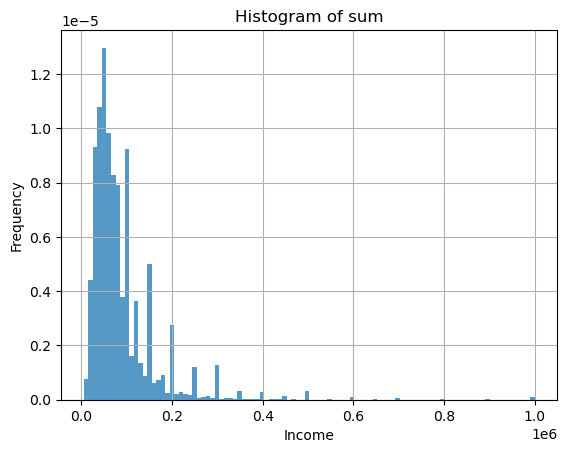

In [25]:
n, bins, patches = plt.hist(y_train, 100, density=True, alpha=0.75)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Histogram of sum')
plt.grid(True)
plt.show()

На гистограмме видим длинный хвост распределения. 

**Вопрос:** Почему нужно убрать выделяющиеся наблюдения?

**Подсказка:** Какую функцию минимизируем при вычислении оценок коэффициентов? Что произойдет, если вычислим ее на большом значении целевой переменной? Как это повлияет на модель?

**Ответ:** выбросы "смещают" гиперплоскость линрега относительно себя

Исключим из обучающей выборки наблюдения, попадающие за 95-квантиль распределения:

In [28]:
X_train = X_train[y_train <= np.percentile(y_train, 95)]
y_train = y_train[y_train <= np.percentile(y_train, 95)]


Вычислим логарифм дохода:

In [30]:
y_train = np.log(y_train.clip(lower=1)) 
y_test =  np.log(y_test.clip(lower=1)) 

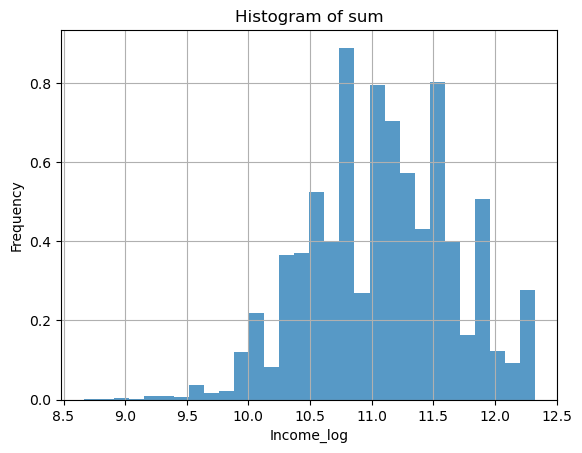

In [31]:
n, bins, patches = plt.hist(y_train, 30, density=True, alpha=0.75)
plt.xlabel('Income_log')
plt.ylabel('Frequency')
plt.title('Histogram of sum')
plt.grid(True)
plt.show()

---

Немного про обучение модели линейной регрессии.

Для обучения модели линейной регрессии будем использовать sklearn: в нем понятный и простой интерфейс. Также можно использовать statsmodels (в нем более обширный функционал и реализованы статистические тесты).

В sklearn есть несколько классов, реализующих линейную регрессию:

- LinearRegression — "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $$a=(𝑋^𝑇𝑋)^{−1}𝑋^𝑇𝑦$$
- Ridge — линейная регрессия с оптимизацией MSE и ℓ2-регуляризацией
- Lasso — линейная регрессия с оптимизацией MSE и ℓ1-регуляризацией


У моделей из sklearn есть методы fit и predict. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй (вызываем после метода fit) возвращает предсказание на выборке. 

## Часть 2. Подготовка данных для применения модели

На лекции мы обсудили предположения, в которых уместно применять модель линейной регрессии: $X^TX$ - невырожденная матрица, 
𝑦 линейно зависит от $x$, остатки $\varepsilon_i$ независимы и $\varepsilon_i \sim N(0,\sigma)$.

На практике эти предположения гарантируются при выполнении условий:
 
1. **Линейность зависимости предикторов и таргета**

2. **Гомоскедастичность**
	$$De = \sigma^{2}I$$
    
3. **Нормальность ошибок**
	$$e \sim N_{n}(0,\sigma^{2}I)$$

4. **Отсутствие мультиколлинеарности**
	$$rank(X) = m + 1 $$

### Линейность зависимости

При постановке задачи мы сделали предположение о линейной зависимости целевой переменной $y$ от предикторов $x_i$. 

Проверить линейность можно графически. Для этого нужно визуализировать\* зависимость между предиктором и целевой переменной (например, с помощью диаграммы рассеивания).


\* При слишком большом количестве точек они обычно группируются по бакетам.

В качестве метрики оценки линейности признака можно использовать $R^2$ простой линейной регрессии на выбранном признаке относительно целевой переменной. 

#### Scatterplot

Построим диаграмму рассеивания для некоторых признаков:

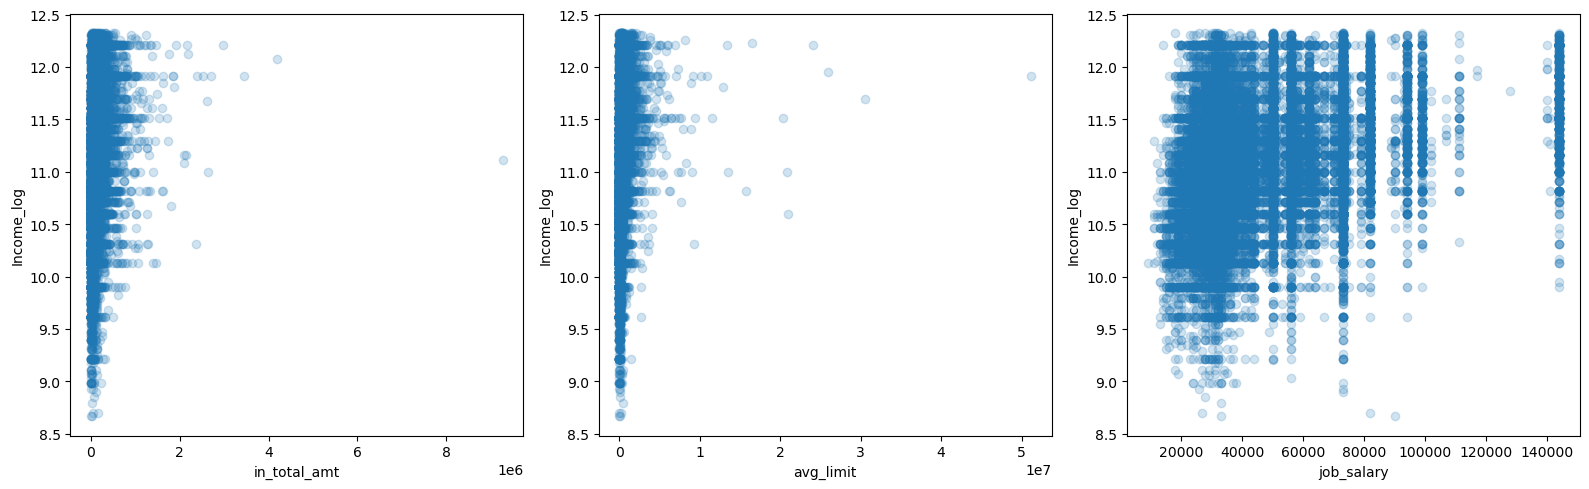

In [42]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(['in_total_amt','avg_limit','job_salary']):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Income_log")
plt.tight_layout()
plt.show()

### Feature_line

В случае, когда наблюдений очень много (как в нашей выборке), можно разбить признак по бакетам и построить среднее и квантили целевой переменной для каждого бакета. Такую визуализацию будем называть feature_line. 

Алгоритм построения feature_line:

1. Сгруппируем наблюдения по бакетам признака (бакеты одного размера, для непрерывных признаков можем использовать количество бакетов nbins > 10) 

2. Вычислим среднее значение целевой переменной для каждого бакета признака (соединим их пунктирной линией) 

3. Для каждого бакета добавим квантили $0.25$ и $0.75$ (обозначим вертикальными линиями)



![feature_line_.png](feature_line_.png)

И выведем гистограмму распределения признака:

![feature_line_hist_.png](feature_line_hist_.png)

Feature_line позволяет оценить характер зависимости целевого признака от предиктора. 
На примере feature_line признака in_total_amt видно, что зависимость не линейная, у распределения длинный хвост (крайний бакет расположен около точки 380000), значения целевой переменной как будто "загибаются" при больших значениях признака.

$R^2=0.055$

[Задание 1](#task1)

### Преобразования

Когда признак нелинейный, может помочь:
- непрерывное монотонное преобразование, линеаризующее признак (это может быть логарифмирование, возведение в квадрат и т.д. В частных случаях бывают и другие типы функций,например, парабола)
- разбиение переменной на линейные фрагменты

**Вопрос:** Почему важна монотонность преобразования?

Лианеризуем признак in_total_amt. Для преобразования этого признака выберем функцию логарифма.

![feature_line_log.png](feature_line_log.png)

Гистограмма распределения признака выглядит так

![feature_line_log_hist.png](feature_line_log_hist.png)

Видно, что признак "распрямился". Значение метрики $R^2$ так же увеличилось.

### Ограничения значений признака

На графике feature_line для непреобразованного значения видно, что наблюдения из хвоста распределения сгруппированы в крайний бакет с серединой ~380000. Можем ограничить экспертно значением 400000.

На графике feature_line логарифмированного признака видно, что слева значение целевой переменной находится на "плато". Линейной зависимости в этом случае не будет. Ограничим признак снизу, например значением 3000. 

**Вопрос:** Можем ли ограничить признак "сильнее"? 

**Ответ:** нежелательно! Теряем экстраполирующую способность модели.

![feature_line_log_limit.png](feature_line_log_limit.png)

![feature_line_log_limit_hist.png](feature_line_log_limit_hist.png)

Видим, что метрика $R^2$ увеличилась на $0.02$.

Сохраним значения преобразованного признака:

In [64]:
X_train['in_total_amt_log'] = np.log(X_train['in_total_amt'].clip(lower=3000, upper=400000))
X_test['in_total_amt_log'] = np.log(X_test['in_total_amt'].clip(lower=3000, upper=400000))

[Задание 2](#task2)

### Проверим гомоскедастичность

Необходимо проверить, что признаки гомоскедастичны, то есть дисперсия ошибки константна на всем предсказании и формально
$$De = \sigma^{2}I$$
Нарушение данного условия приводит к неэффективности оценок регрессии и несоответствию оценок МНК и ОМП

**Способы проверки**: 
- построить график зависимости остатка от предсказания (по необходимости с разбиением на бакеты)
- зависимость разброса от предсказания будет свидетельствовать о гетероскедастичности  
- статистические тесты (к сожалению, универсального нет - каждый позволяет найти гетероскедастичность только определенного вида)

**Способы решения проблемы**
- Преобразование целевой переменной, приводящее к равномерности разброса
- В случае диагональности матрицы ковариаций возможно применение обощенного [МНК]

  $$\hat{a} = (X^{T}\Omega^{-1}X)^{-1}X^{T}\Omega^{-1}y, \;где\; \Omega^{-1} - матрица\; ковариаций\; остатков$$

Мы уже преобразовали целевую переменную (логарифмированием). Поэтому проверим, что было до преобразования переменной и признака in_total_amt, и сравним с тем, что стало после.

#####  Графический тест
Гетероскедастичность будет наблюдаться, если при изменении предсказания будет меняться величина разброса 

In [70]:
def get_residuals(Y,Pred):
    '''Подсчет невязки Y - истинное значение таргета, Pred - предсказанное'''
    return Y - Pred

In [71]:
def check_homoscedacity(predictor,target,f_name):
    simple_model = LinearRegression()
    simple_model.fit(predictor.reshape(-1,1),target)
    predicts = simple_model.predict(predictor.reshape(-1,1))
    return (plt.scatter(predicts,get_residuals(target,predicts)))

Визуализируем зависимость для предсказания линейной регрессии от непреобразованного признака in_total_amt и целевой переменной:

In [73]:
def make_bucket(df,feature, n =  100):
    '''функция, бьющая на бакеты(по умолчанию 100 точек)'''
    return df.assign(bucket = np.ceil(df[feature].rank(pct = True) * n))

In [74]:
def plot_homoscedacity(predictor, target, predictor_name='feature'):
    df_tmp = pd.DataFrame({'predictor':predictor, 'target':target})
    return df_tmp.pipe(make_bucket,'predictor',200)\
                 .groupby(by = ['bucket']).mean()\
                 .pipe(lambda x:check_homoscedacity(np.array(x.predictor),np.array(x.target),predictor_name)) 

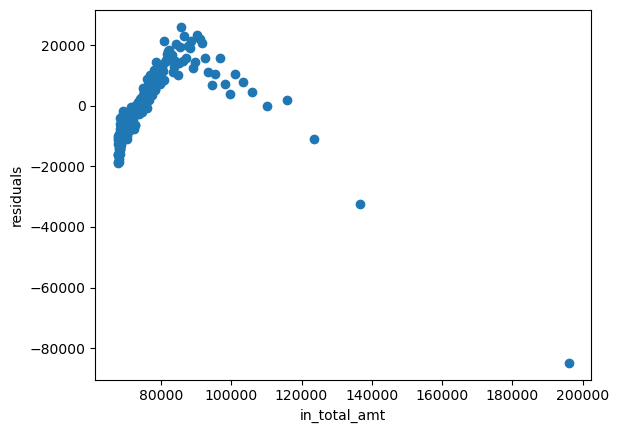

In [75]:
plot_homoscedacity(X_train.in_total_amt, np.exp(y_train),'in_total_amt')
plt.xlabel('in_total_amt')
plt.ylabel('residuals')
plt.show()

Видно, что для признака in_total_amt гомоскедастичность не выполнена (остатки зависят от значения предсказания)

Визуализируем зависимость для предсказания линейной регрессии для преобразованного признака in_total_amt_log и преобразованной целевой переменной:

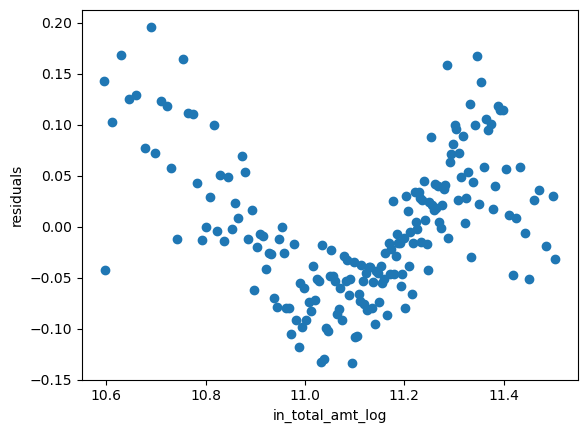

In [78]:
plot_homoscedacity(X_train.in_total_amt_log, y_train,'in_total_amt_log')
plt.xlabel('in_total_amt_log')
plt.ylabel('residuals')
plt.show()

[Задание 3](#task3)

### Нормальность остатков

Необходима для эквивалентности оценок МНК и ОМП

**Способы проверки**
- Статистические критерии
- Построение гистограммы распределения ошибок простой линейной регрессии по признакам или всей модели
- Построение графика QQ-plot (https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)

**Способы решения проблемы**
- преобразование признака, приводящее к нормальному распределению
- исключение признака из регрессии

In [82]:
numeric_final = ['in_total_amt_log','avg_limit', 'gender', 'job_salary']

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


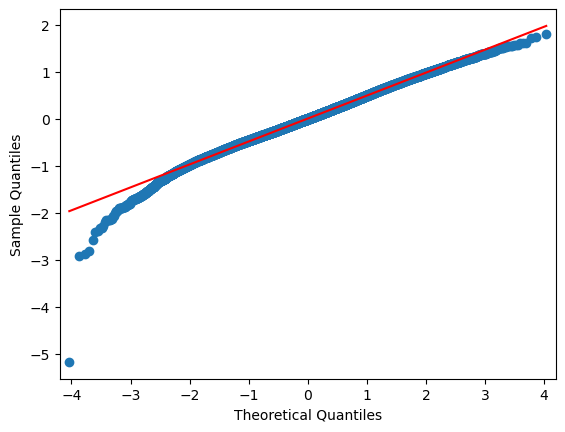

In [83]:
import statsmodels.api as sm
import pylab as py

model = LinearRegression()
model.fit(np.array(X_train[numeric_final]),y_train)
resids = get_residuals(y_train,(model.predict(X_train[numeric_final])))
  
# np.random generates different random numbers
# whenever the code is executed
# Note: When you execute the same code 
# the graph look different than shown below.
  
# Random data points generated
data_points = np.random.normal(0, 1, 100000)    
  
sm.qqplot(np.array(resids), line='s')
py.show()

На этом графике qq-plot видно, что точки не лежат на прямой. Посмотрим на гистограмму распределения остатков.

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


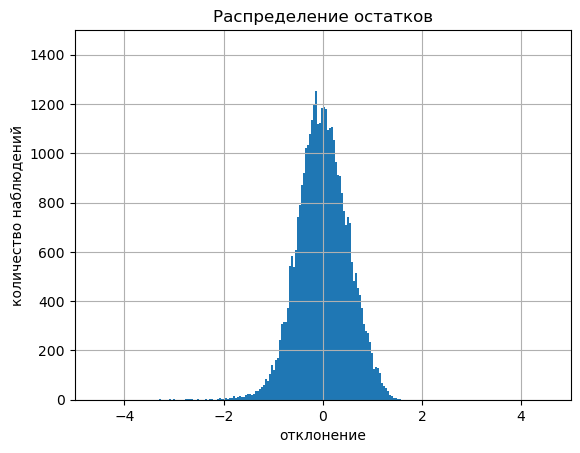

In [85]:
model = LinearRegression()
model.fit(np.array(X_train[numeric]),y_train)
resids = get_residuals(y_train,(model.predict(X_train[numeric])))
plt.hist(resids, bins='auto')[2]
plt.xlabel('отклонение')
plt.ylabel('количество наблюдений')
plt.title('Распределение остатков')
plt.axis([-5, 5, 0, 1500])
plt.grid(True)
plt.show()

Если внимательно посмотреть на распределение, можно увидеть небольшую ассиметричность: "хвосты" распределения немного отличаются.
    
На qq-plot это легко увидеть - в левой части графика точки находятся ниже прямой, т.е. квантили выборочного распределения смещены относительно теоритическиx.

### Мультиколлинеарность

Мультиколлинеарность - проблема близости матрицы X к какой-либо матрице неполного ранга (то есть сильной зависимости признаков между собой).В этом случае матрица $X^TX$ будет плохо обусловленной и решения будут неустойчивыми.

Проверить отсутствие мультиколлинеарности можно:
1. Построив корреляционную матрицу. Если значение коэффициента корреляции >0.3 следует более подробно изучить коррелирующие признаки и преобразовать их или исключить менее эффективный
    
2. Вычислив VIF (Variance Inflation Factor)

**Главная проблема:** сходимость к глобальному экстремуму!

#### Проверка коэффициентов корреляции между парами признаков

Проверим, есть ли коррелирующие переменные с выборочным коэффициентов корреляции $>0.3$. Для этого построим матрицу корреляций:

C:\Users\smirn\AppData\Local\Temp\ipykernel_22032\165153338.py:1: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


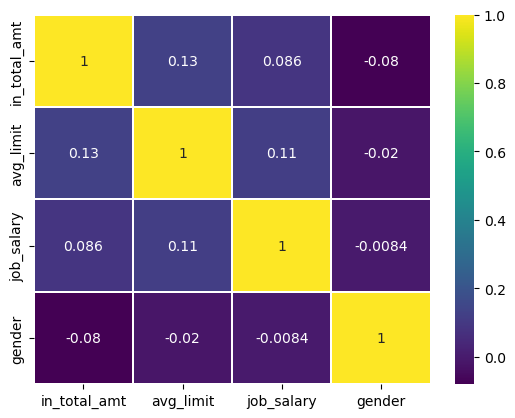

In [92]:
from scipy.stats.stats import pearsonr   
import seaborn as sns

pcorr = pd.DataFrame 
pcorr = []
for f1 in numeric:
    for f2 in numeric:
        pcorr.append((f1,f2,pearsonr(X_train[f1],X_train[f2])))
        
cor = X_train.loc[:,numeric].corr(method='pearson')
cm=plt.cm.viridis
sns.heatmap(cor,cmap=cm,linewidths=0.1,linecolor='white',annot=True)
plt.show()

Видим, что коэффициенты корреляции небольшие (меньше 0.3). 

#### Variance Inflation Factor

Variance Inflation Factor (VIF) позволяет обнаружить корреляцию признака со всеми остальными в совокупности. 

Для вычисления VIF строится k моделей линейной регрессии (здесь k - это количество признаков).

 - i-ый признак выбирается как целевая переменная, оставшиеся признаки - как предикторы. Строится модель линейной регрессии.
 - для предсказанных значений вычисляем VIF:
$$VIF_{i} = \frac{1}{1 - R^{2}_{i}}$$

**Вопросы**: 
   - При каких значениях VIF есть подозрение на линейную зависимость?

Частый стандарт - от 10; главная мысль - чем выше VIF, тем более признак "линейно выражаем" через другой (ие) признаки в модели.

Вычислим значение Variance Inflation Factor для признаков:

In [98]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame(data = {'feature':[i for i in numeric],
                     'VIF':[round(variance_inflation_factor(X_train[numeric].values,i),2) for i in range(len(numeric))]}).set_index('feature')

VIF
feature           
in_total_amt  1.40
avg_limit     1.18
job_salary    1.87
gender        1.38

[Задание 4](#task3)

## Baseline

Построим Baseline

In [102]:
numeric_final = ['in_total_amt_log','avg_limit', 'gender', 'job_salary']

In [103]:
fit_predict(X_train, y_train, X_test, y_test, numeric_final);

R2_train: 0.2627
R2_test: 0.2741


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


[Задание 5](#task5)

## Качество модели

Немного про интерпретацию $R^2$.

### Интерпретация $R^2$:

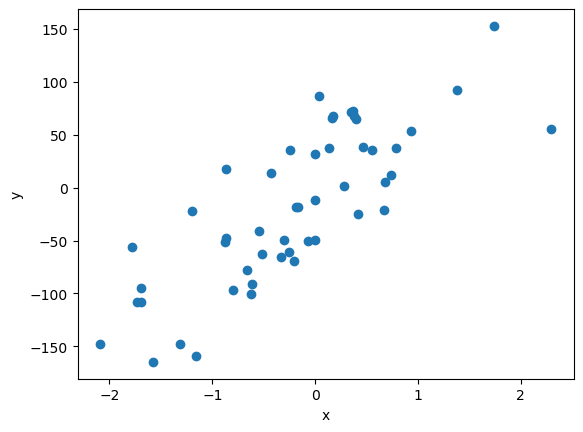

In [108]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=50, n_features=1, n_informative=1, noise=50, random_state=89)

plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y");

На лекции мы говорили, что метрика $R^2$ означает долю объясненной с помощью линейной модели дисперсии $y$. Разберемся с этим определением подробнее.

Дисперсия – это средний квардрат разброса наблюдений вокруг выборочного среднего:

In [110]:
message = (
    f"Variance by definition: {np.mean( (y - np.mean(y)) ** 2 )}\n"
    f"Variance using function: {np.var(y, ddof=0)}"  # ddof=0 означает, что в знаменателе будет n-0, а не n-1
)

print(message)

Variance by definition: 5283.500549191376
Variance using function: 5283.500549191376


Визуализируем разброс: 

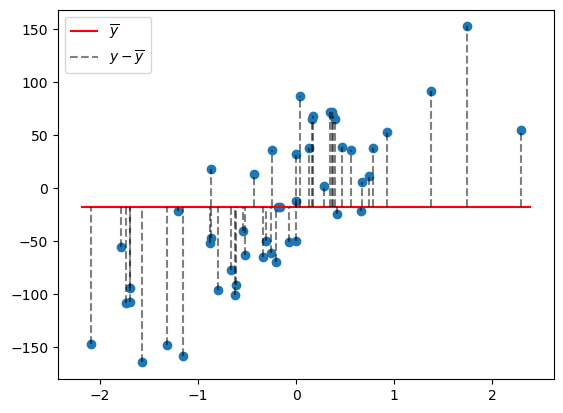

In [112]:
plt.scatter(X, y)

# средний y
plt.hlines(y=np.mean(y), xmin=-2.2, xmax=2.4, color="r", label=r"$\overline{y}$")

# минимум и максимум из двух массивов поэлементно
ymin = np.minimum(y, np.mean(y))
ymax = np.maximum(y, np.mean(y))

# рисуем отклонения от среднего
plt.vlines(x=X, ymin=ymin, ymax=ymax, color="k", linestyles="dashed", alpha=0.5, label=r"$y - \overline{y}$")

plt.legend();
plt.show()

Итак, дисперсия – это сумма квадратов отклонений от среднего (пунктирная линия). Теперь попробуем теперь расчитать **разброс вокруг линии регрессии**:

In [114]:
coef = np.linalg.inv( X.T @ X ) @ X.T @ y  # коэффициенты линейной регрессии
reg_line = X @ coef                        # линия регрессии

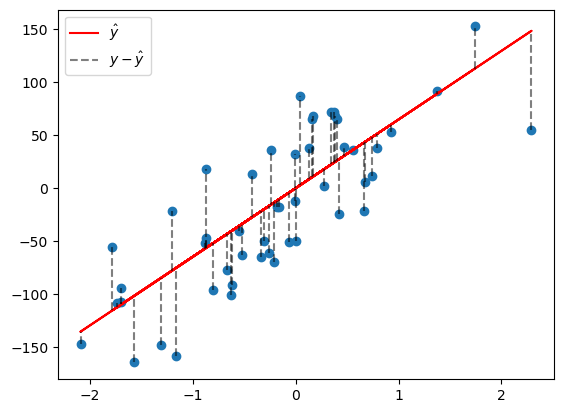

In [115]:
plt.scatter(X, y)
plt.plot(X, reg_line, color="r", label=r"$\hat{y}$")

# минимум и максимум из двух массивов поэлементно
ymin = np.minimum(y, reg_line)
ymax = np.maximum(y, reg_line)

# рисуем отклонения от среднего
plt.vlines(x=X, ymin=ymin, ymax=ymax, color="k", linestyles="dashed", alpha=0.5, label=r"$y - \hat{y}$")

plt.legend()
plt.show()

Итак, мы построили такой же график с разбросом вокруг регрессионной прямой, как и вокруг среднего. Можно заметить, что ошибка в среднем стала меньше – **длины пунктирных линий уменьшились**. Метрика $R^2$ и отвечает на вопрос, насколько в среднем уменьшилась ошибка при переходе от предсказания выборочным средним к регрессии:

$$
R^2 = 1 - \frac{\sum (y_i - \hat y) ^ 2}{\sum (y_i - \overline y) ^ 2}
$$

 - если $R^2 = 0$, это означает, что $\sum (y - \hat y) ^ 2 = \sum (y - \overline y) ^ 2$ – линейная регрессия предсказывает так же, как и выборочное среднее.
 - если $R^2 = 1$, это означает, что $\sum (y - \hat y) ^ 2 = 0$ – все наблюдения расположены на регрессионной прямой.ь

**Вопрос**: Может ли $R^2$ быть отрицательным?

**Ответ:** Да, может. Если мы построим модель, которая предсказывает константную модель... (1 - > 1 => < 0). То есть, прямая проведена с правильным трендом, но мимо точек - $R^2$ уползёт в отрицательные значения.

 [Задание 6](#task6)

## Домашнее задание 2: Линейная регрессия
### (10 баллов)

#### Подготовка

In [121]:
df = pd.read_csv('./income_dataset.csv',sep=';')
df

id   in_total_amt    income  job_salary  gender   age  car_own_flg  \
0          0    8110.825000   30000.0       32000       1  22.0            0   
1          1   25600.000000   50000.0       32000       0  26.0            0   
2          2  216091.400000   30000.0       38000       0  25.0            0   
3          3  106000.661389   50000.0       40000       0  36.0            0   
4          4  102672.375000   50000.0       17000       0  23.0            0   
...      ...            ...       ...         ...     ...   ...          ...   
55195  55195   29282.480000  650000.0       73000       0  27.0            0   
55196  55196    9650.000000   48234.0       29000       1  41.0            0   
55197  55197  185333.333333  200000.0      144000       0  37.0            0   
55198  55198   12200.000000   50000.0       37000       1  37.0            0   
55199  55199   31330.737333   50000.0       33000       0  29.0            0   

          avg_limit  max_limit  credit_num  acc_num  out_total_amt  
0       12847.00000    23862.0           7      9.0   38657.606406  
1       26381.50000    24611.0           3      7.0   51272.839585  
2        9176.48857    33998.0          14      3.0  147950.296174  
3       32152.50000    23451.0           4      6.0   99925.392161  
4       38493.50000   585000.0           9      7.0   78125.045718  
...             ...        ...         ...      ...            ...  
55195   17874.00000        0.0           2      5.0   84105.622110  
55196  168401.50000        0.0           2      7.0   68372.873056  
55197  729903.19714   800000.0          16      7.0  359484.607452  
55198   97232.33333   246015.0           7      6.0   61308.665102  
55199   11932.33333    10806.0           3      8.0   50900.264984  

[55200 rows x 12 columns]

In [122]:
print(len(df))

55200


- id - уникальный id клиента
- in_total_amt - среднемесячные пополнения карты 
- gender - пол (1 - женский, 0 - мужской)
- age - возраст
- car_own_flg - наличие авто
- avg_limit - средняя сумма кредита
- max_limit - максимальная сумма кредита
- job_salary - средняя зарплата по должности
- credit_num - количество кредитов
- acc_num - количество счетов
- out_total_amt - среднемесячные траты

**Целевая переменная:** income

In [124]:
numeric_features = [ 'in_total_amt', 'avg_limit', 'job_salary','gender'] # остальные признаки попадают в домашнее задание
other_features = ['age', 'car_own_flg', 'max_limit', 'credit_num', 'acc_num', 'out_total_amt']

features = numeric_features + other_features

<a id='task1'></a>
##### Задание 1 (3 балла)

1. Реализовать функцию feature_line(var, target, nbins)

    В качестве аргументов функция должна принимать:
     - var: вектор значений признака
     - target: вектор значений целевой переменной
     - nbins: количество бакетов

    и возвращать:
     - график линейности признака
     - количество удаленных наблюдений
     - значение метрики R2
     - гистограмму распределения признака
 
 
2. Проверить линейность признаков с помощью функции feature_line()

In [127]:
def feature_line(var, target, nbins):

    # сделаю внутренний импорт
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score

    # преобразование в df для удобства
    bins = nbins
    df = pd.DataFrame({'var': var, 'target': target})

    # кол-во удаленных наблюдений, уберем просто пропуски
    df_count = len(df)

    # удаляем пропуски
    df_drop = df.dropna().copy()

    df_drop_count = len(df_drop)
    number_of_deleted_values = df_count - df_drop_count

    # теперь работаем с очищенным от пропусков df
    df = df_drop


    # добавим бакеты
    df['bin'] = pd.qcut(df['var'], q=nbins, duplicates='drop')

    # агрегация по выб-м хар-кам
    agg = (
        df.groupby('bin', observed=True)
          .agg(
              x_mean=('var', 'mean'),
              y_mean=('target', 'mean'),
              q25=('target', lambda s: s.quantile(0.25)),
              q75=('target', lambda s: s.quantile(0.75)),
              n=('target', 'size')
          )
          .reset_index()
          .sort_values('x_mean')
    )

    # линрег по данным
    X_all = df[['var']].to_numpy()
    y_all = df['target'].to_numpy()

    lr = LinearRegression()
    lr.fit(X_all, y_all)

    y_all_hat = lr.predict(X_all)
    r2_all = r2_score(y_all, y_all_hat)

    print(f"Удалено наблюдений: {number_of_deleted_values}")

    sns.set_style("darkgrid")

    # График feature_line
    fig1, ax1 = plt.subplots(figsize=(14, 5))

    # квантили
    ax1.vlines(
        x=agg['x_mean'],
        ymin=agg['q25'],
        ymax=agg['q75'],
        colors='#b22222',
        linewidth=2,
        alpha=0.95
    )

    # пунктир
    ax1.plot(
        agg['x_mean'],
        agg['y_mean'],
        linestyle='--',
        marker='o',
        markersize=5,
        color='#b22222',
        linewidth=2,
        label='Target'
    )

    # линрег линия
    x_line = np.linspace(agg['x_mean'].min(), agg['x_mean'].max(), 200).reshape(-1, 1)
    y_line = lr.predict(x_line)
    ax1.plot(
        x_line.ravel(),
        y_line,
        color='royalblue',
        linewidth=2,
        label='Linear Regression'
    )

    # подписи и легенда
    ax1.set_xlabel('Feature')
    ax1.set_ylabel('Target')
    ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=False)

    ax1.text(
        0.01, 1.02,
        f"R_sqr = {r2_all:.4f}",
        transform=ax1.transAxes,
        ha='left', va='bottom',
        fontsize=14, color='slategray'
    )

    plt.tight_layout()
    plt.show()

    # Гистограмма распределения признака
    fig2, ax2 = plt.subplots(figsize=(14, 5))

    sns.histplot(
        data=df,
        x='var',
        hue='bin',
        bins=500,
        multiple='layer',
        stat='count',
        element='bars',
        alpha=1.0,
        ax=ax2,
        legend=True
    )

    ax2.set_xlabel('Feature')
    ax2.set_ylabel('count')
    ax2.set_title('Гистограмма распределения признака', loc='left')

    # легенда справа
    leg = ax2.get_legend()
    if leg is not None:
        leg.set_title("Buckets")
        leg.set_bbox_to_anchor((1.02, 1.0))
        leg._loc = 2

    plt.tight_layout()
    plt.show()

    print(f'{r2_all}')

    return fig1, number_of_deleted_values, r2_all, fig2

Удалено наблюдений: 0


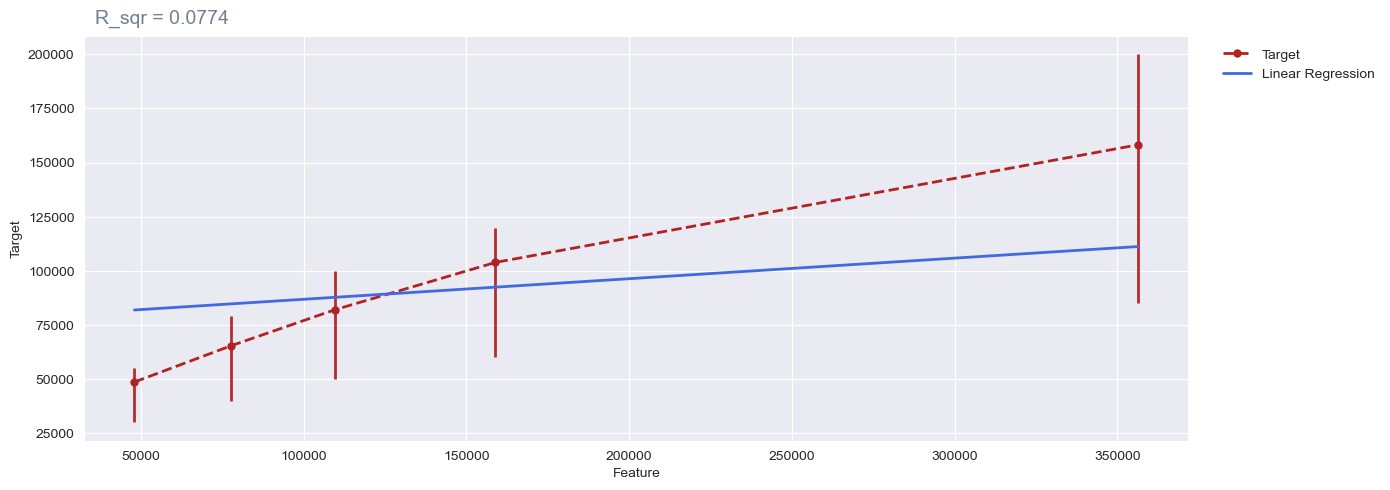

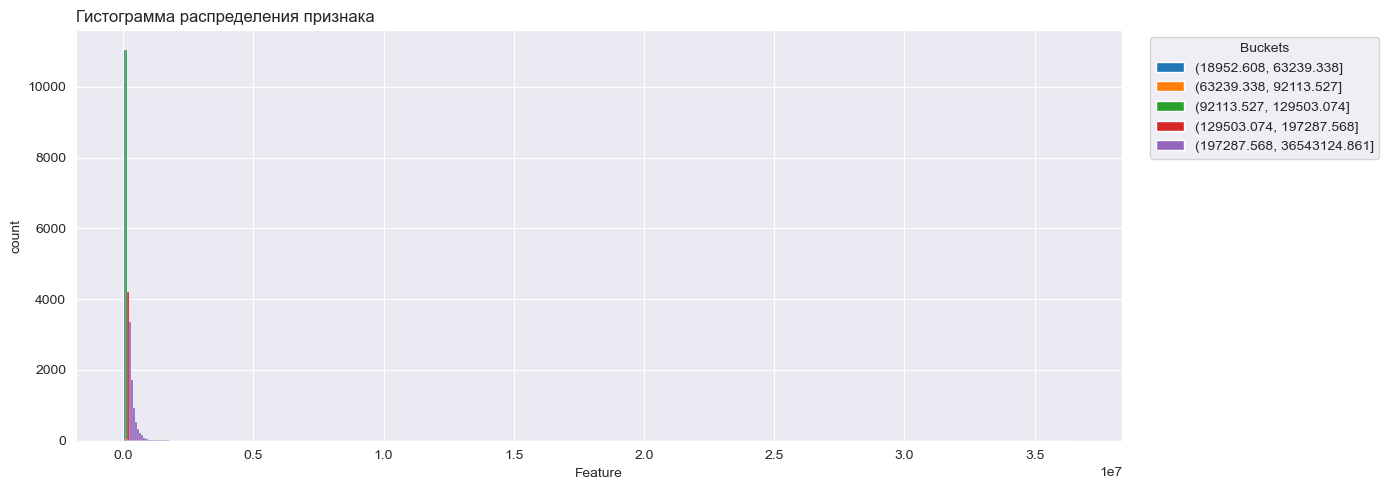

0.07737957663678607


(<Figure size 1400x500 with 1 Axes>,
 0,
 0.07737957663678607,
 <Figure size 1400x500 with 1 Axes>)

In [128]:
feature_line(df['out_total_amt'], df['income'], nbins=5)

<a id='task2'></a>
##### Задание 2 (1 балл)

Подобрать преобразование и линеаризовать признаки (для визуализации использовать feature_line()). Необходимо обосновать выбор преобразования.

Подсказка: линеаризовать признак age можно разбиением на линейные фрагменты

#### Для начала оценим зависимости визуально. 

Использую свою наработку дизайна графиков (тут подробнее: https://github.com/vladimirrsmirnovv/MOEX_research_paper/blob/main/IMOEX_pipeline.ipynb_) помимо основной функции.

In [132]:
df

id   in_total_amt    income  job_salary  gender   age  car_own_flg  \
0          0    8110.825000   30000.0       32000       1  22.0            0   
1          1   25600.000000   50000.0       32000       0  26.0            0   
2          2  216091.400000   30000.0       38000       0  25.0            0   
3          3  106000.661389   50000.0       40000       0  36.0            0   
4          4  102672.375000   50000.0       17000       0  23.0            0   
...      ...            ...       ...         ...     ...   ...          ...   
55195  55195   29282.480000  650000.0       73000       0  27.0            0   
55196  55196    9650.000000   48234.0       29000       1  41.0            0   
55197  55197  185333.333333  200000.0      144000       0  37.0            0   
55198  55198   12200.000000   50000.0       37000       1  37.0            0   
55199  55199   31330.737333   50000.0       33000       0  29.0            0   

          avg_limit  max_limit  credit_num  acc_num  out_total_amt  
0       12847.00000    23862.0           7      9.0   38657.606406  
1       26381.50000    24611.0           3      7.0   51272.839585  
2        9176.48857    33998.0          14      3.0  147950.296174  
3       32152.50000    23451.0           4      6.0   99925.392161  
4       38493.50000   585000.0           9      7.0   78125.045718  
...             ...        ...         ...      ...            ...  
55195   17874.00000        0.0           2      5.0   84105.622110  
55196  168401.50000        0.0           2      7.0   68372.873056  
55197  729903.19714   800000.0          16      7.0  359484.607452  
55198   97232.33333   246015.0           7      6.0   61308.665102  
55199   11932.33333    10806.0           3      8.0   50900.264984  

[55200 rows x 12 columns]

In [133]:
def plot_feature_vs_target_scatter(
    df,
    features_to_plot,
    target_col,
    title="Диаграммы рассеяния: таргет vs признаки"
):

    n = len(features_to_plot)
    ncols = 2 if n > 1 else 1
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 4.5 * nrows))
    if n == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    sns.set_style("whitegrid")
    palette = sns.color_palette("coolwarm", as_cmap=True)

    for i, feature in enumerate(features_to_plot):
        ax = axes[i]

        plot_df = df[[feature, target_col]].dropna()

        sns.scatterplot(
            data=plot_df,
            x=feature,
            y=target_col,
            hue=target_col,        
            palette=palette,
            size=target_col,         
            sizes=(20, 100),
            alpha=0.7,
            edgecolor="black",
            linewidth=0.5,
            ax=ax,
            legend=False
        )

        # sns.regplot(
        #     data=plot_df,
        #     x=feature,
        #     y=target_col,
        #     scatter=False,
        #     lowess=True,
        #     color='red',
        #     line_kws={'linewidth': 2, 'linestyle': '--'},
        #     ax=ax
        # )

        ax.set_title(f'{target_col} vs {feature}', fontsize=13, fontweight='bold')
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel(target_col, fontsize=12)
        ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

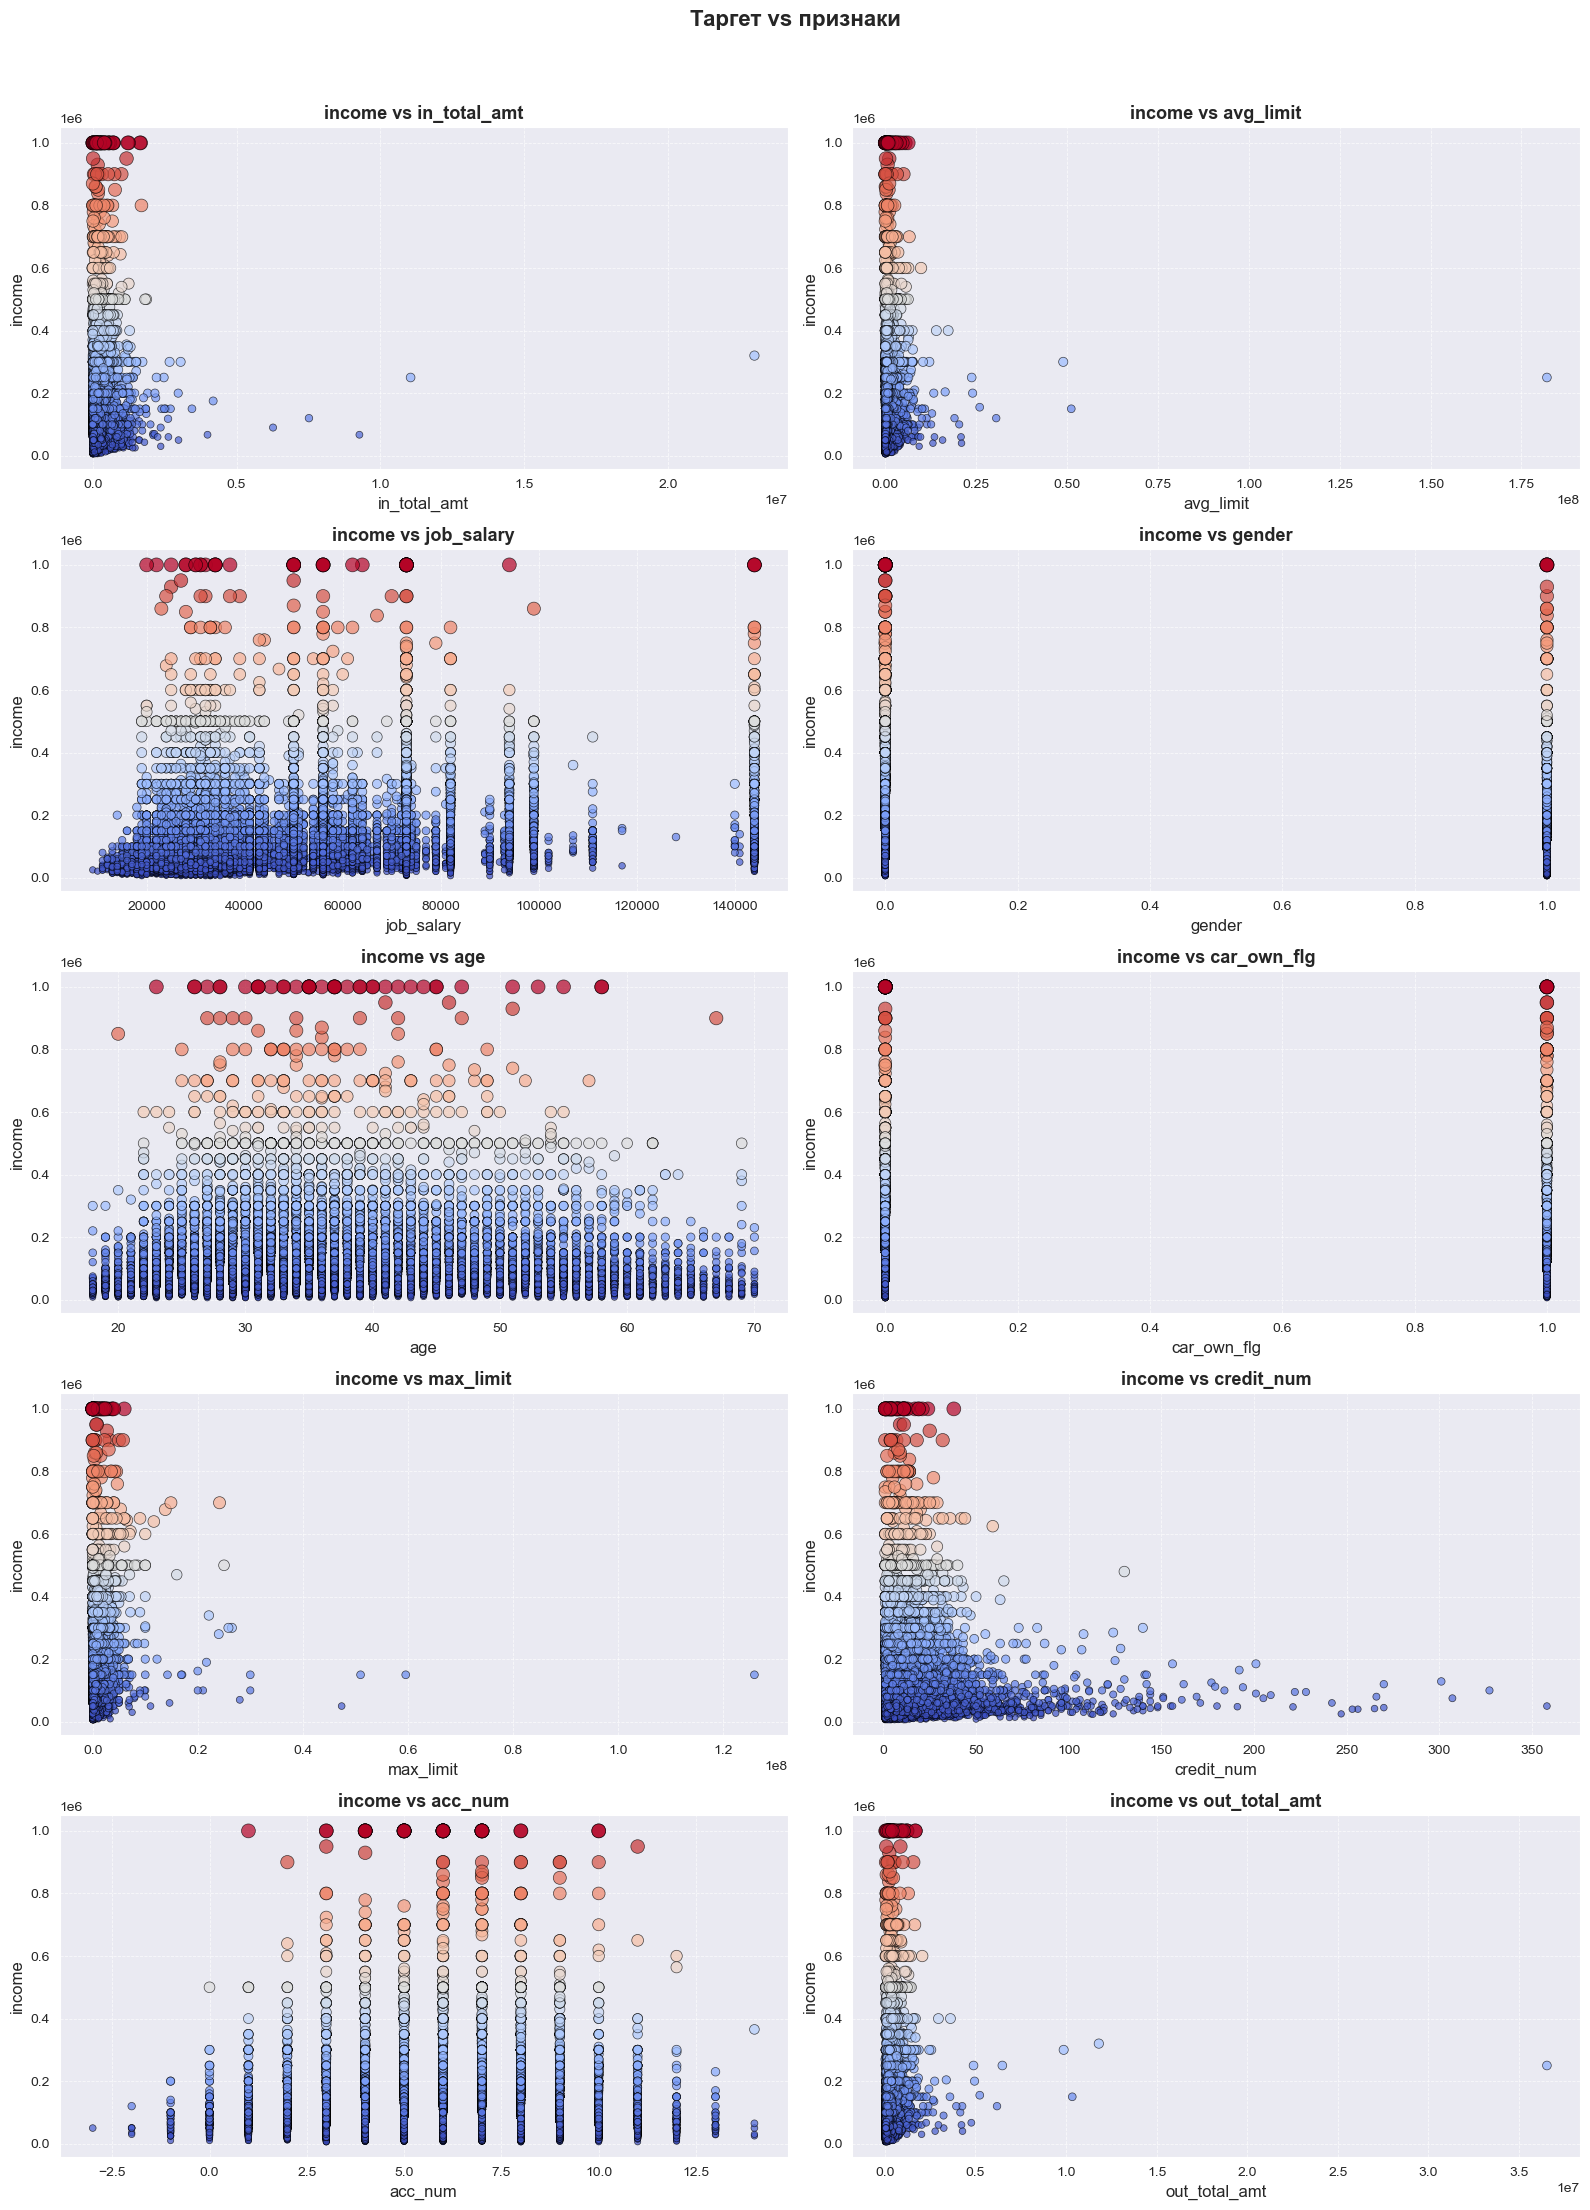

In [134]:
plot_feature_vs_target_scatter(
    df=df,
    features_to_plot=features,
    target_col='income',
    title="Таргет vs признаки"
)

##### Не очень понятно, какие выводы делать! Используя функцию, написанную ранее:

In [136]:
features = [
    'in_total_amt',
    'out_total_amt',
    'job_salary',
    'avg_limit',
    'max_limit',
    'credit_num',
    'acc_num',
    'age',
    'gender',
    'car_own_flg'
]


===== in_total_amt =====
Удалено наблюдений: 0


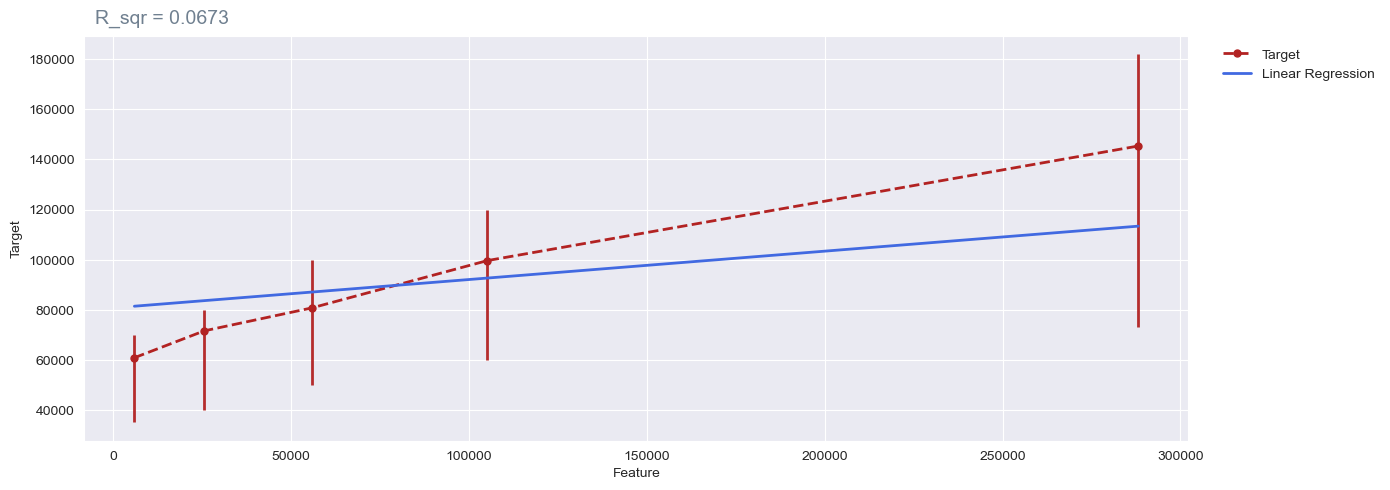

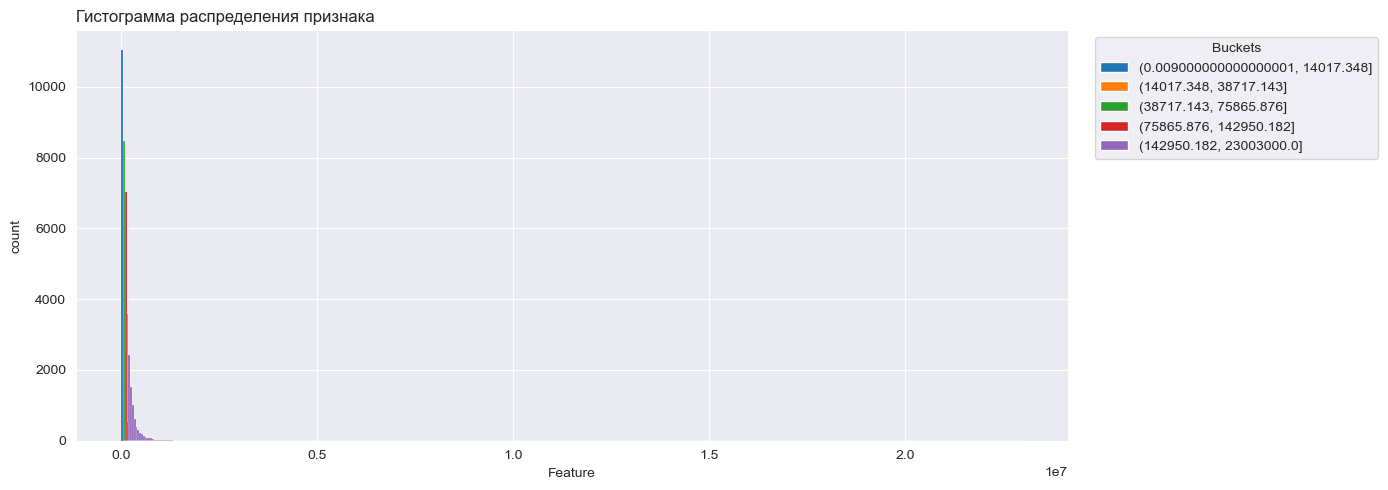

0.06731058039449489

===== job_salary =====
Удалено наблюдений: 0


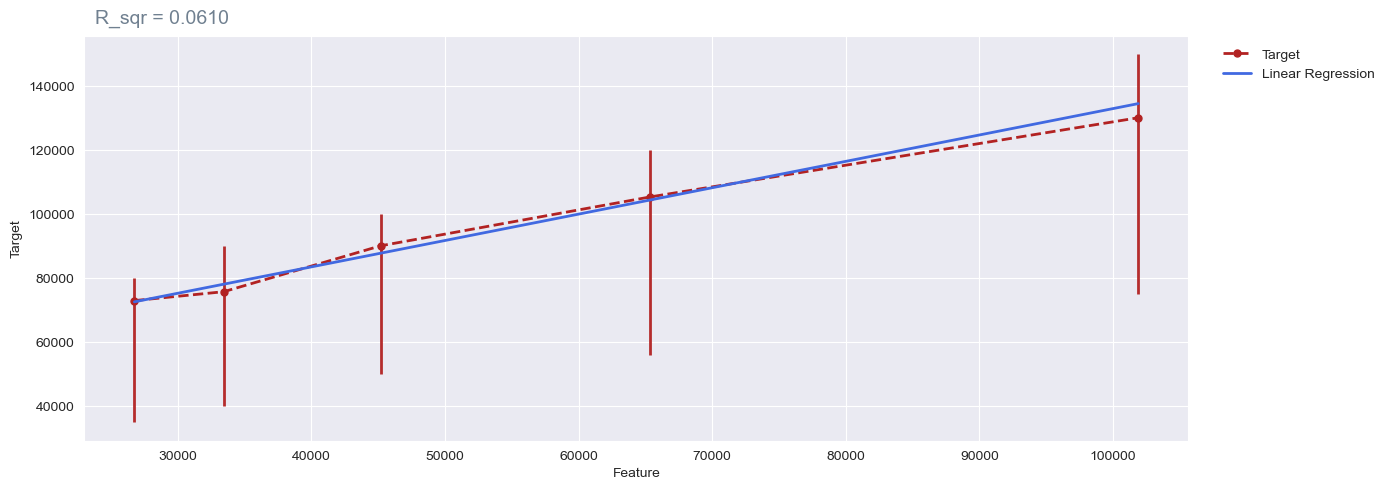

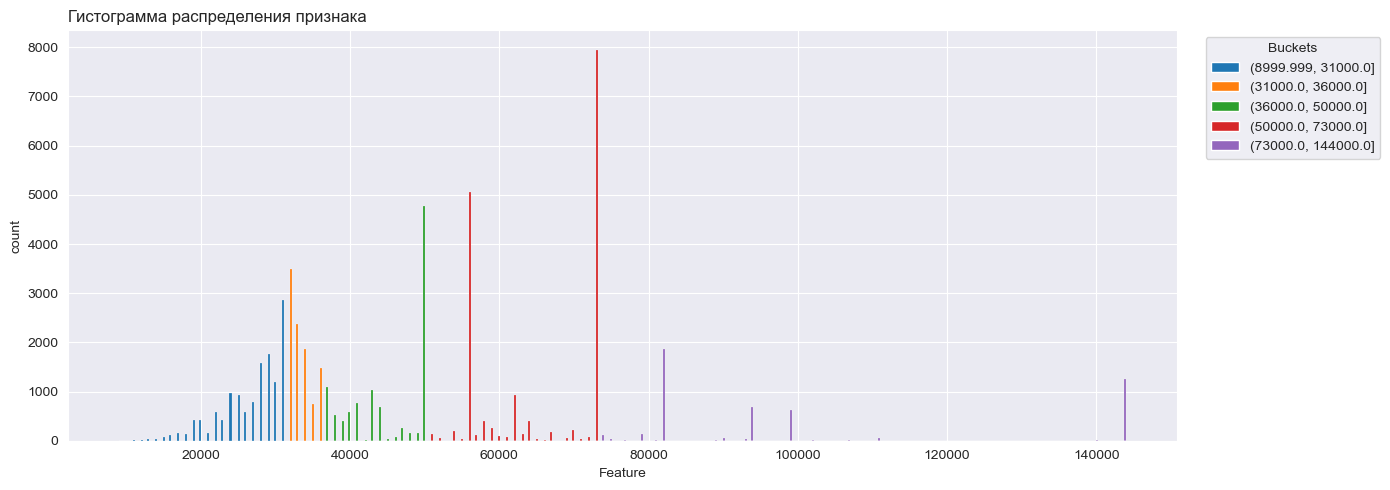

0.06099727332913707

===== gender =====
Удалено наблюдений: 0


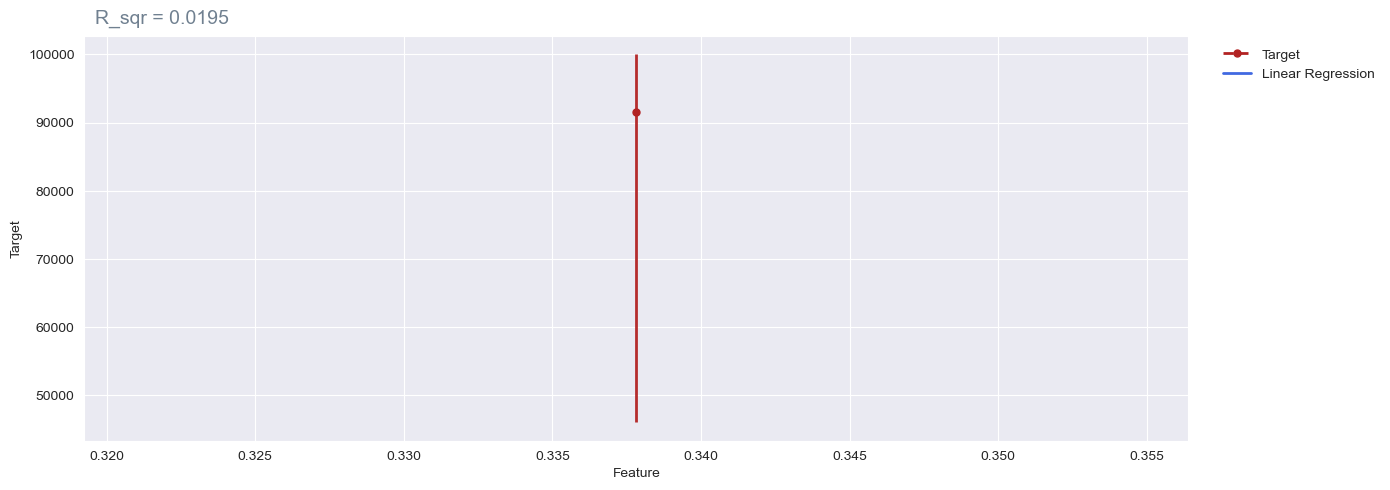

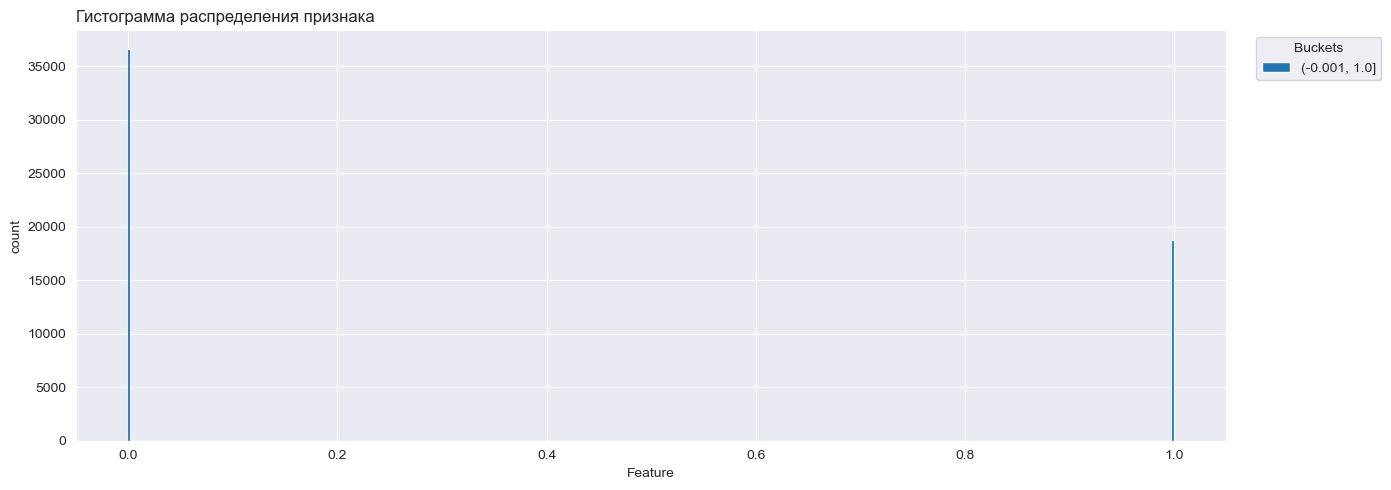

0.019531994819734888

===== age =====
Удалено наблюдений: 0


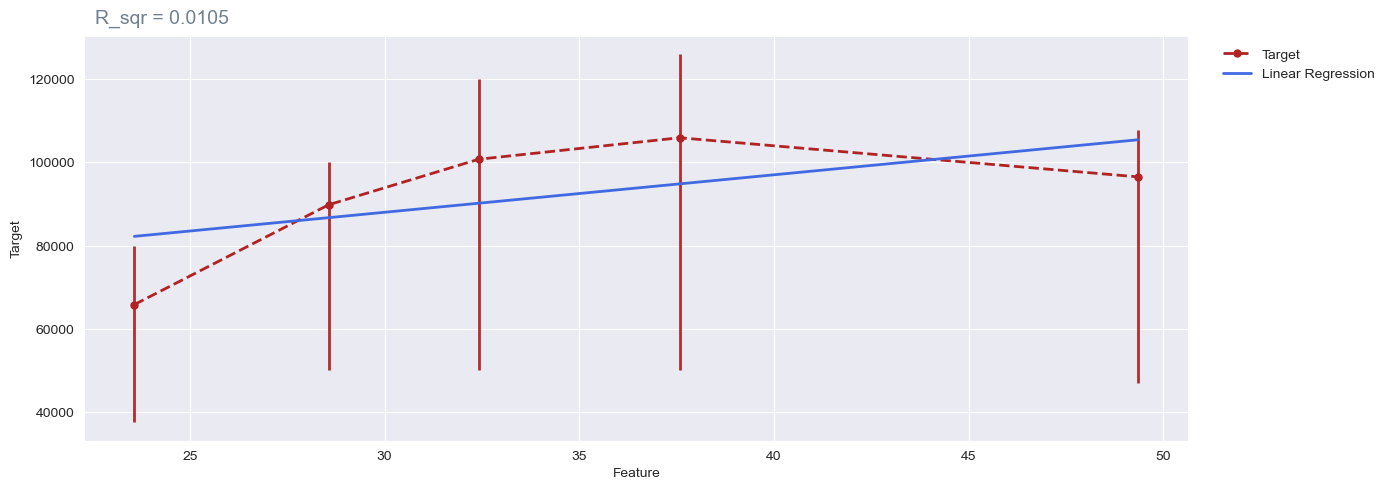

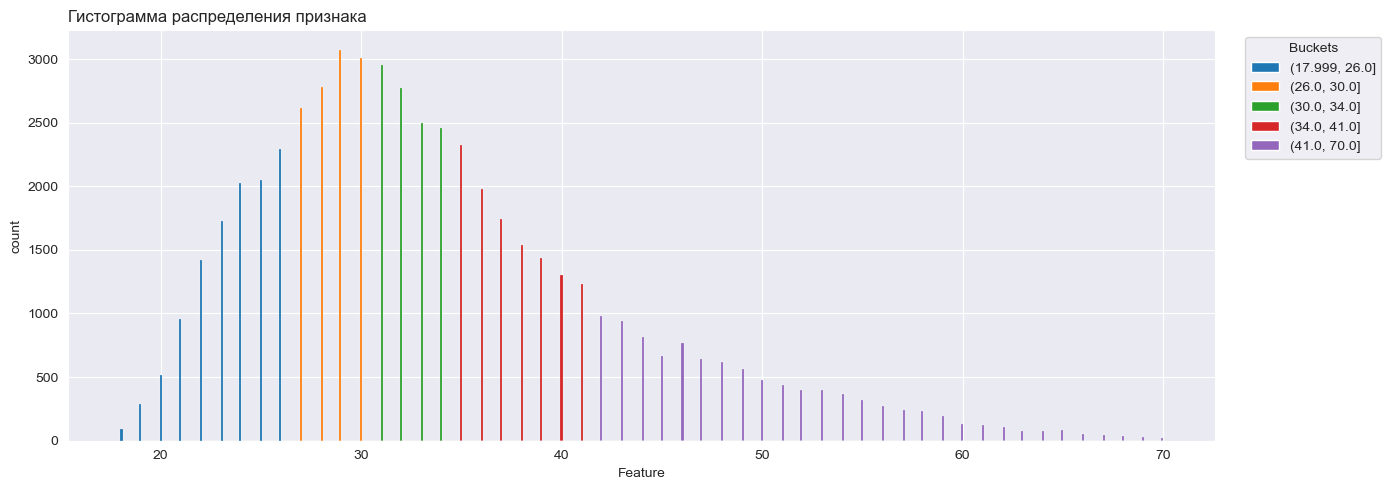

0.010524584071852972

===== car_own_flg =====
Удалено наблюдений: 0


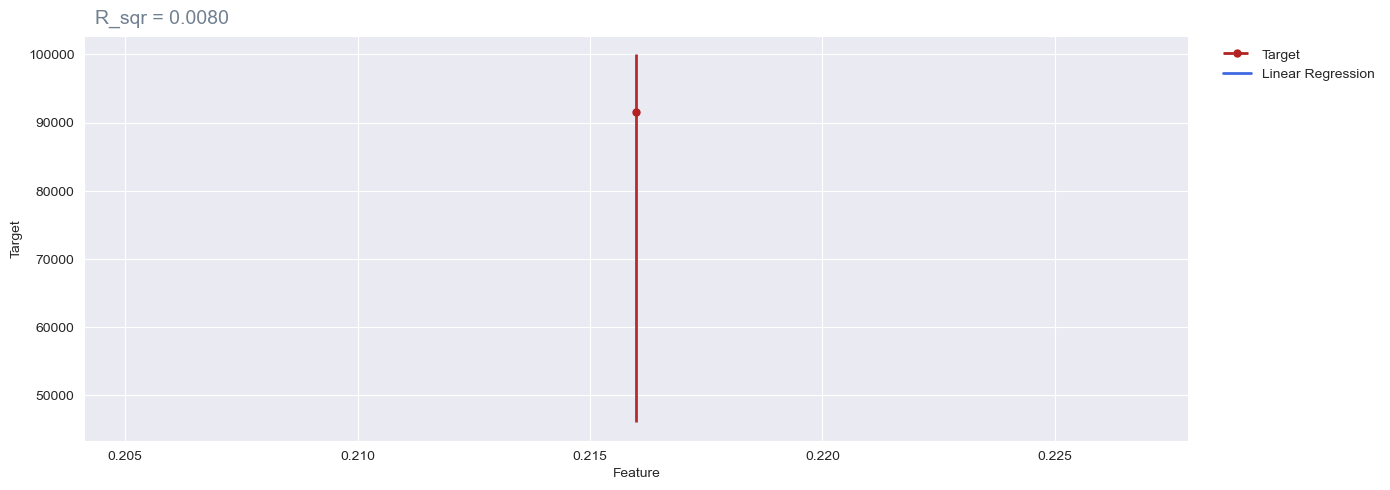

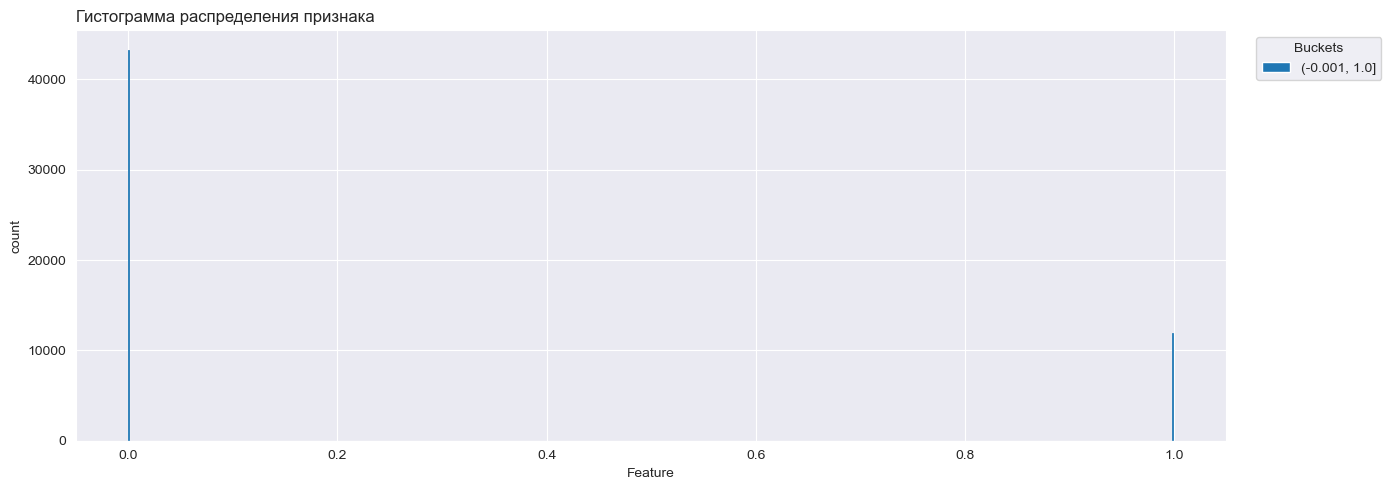

0.007982685857694127

===== avg_limit =====
Удалено наблюдений: 0


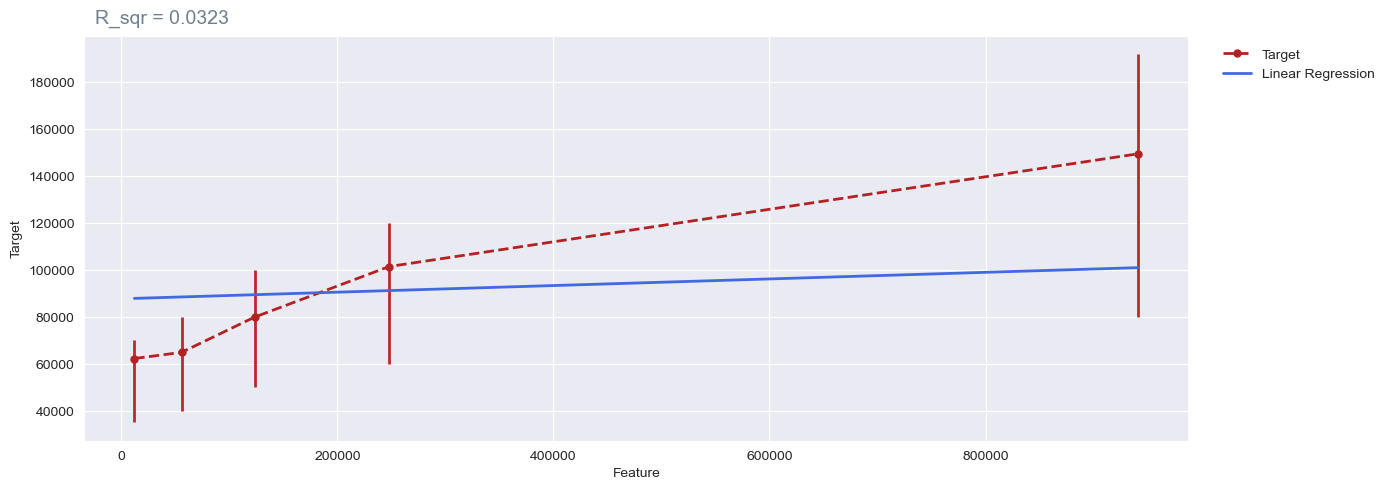

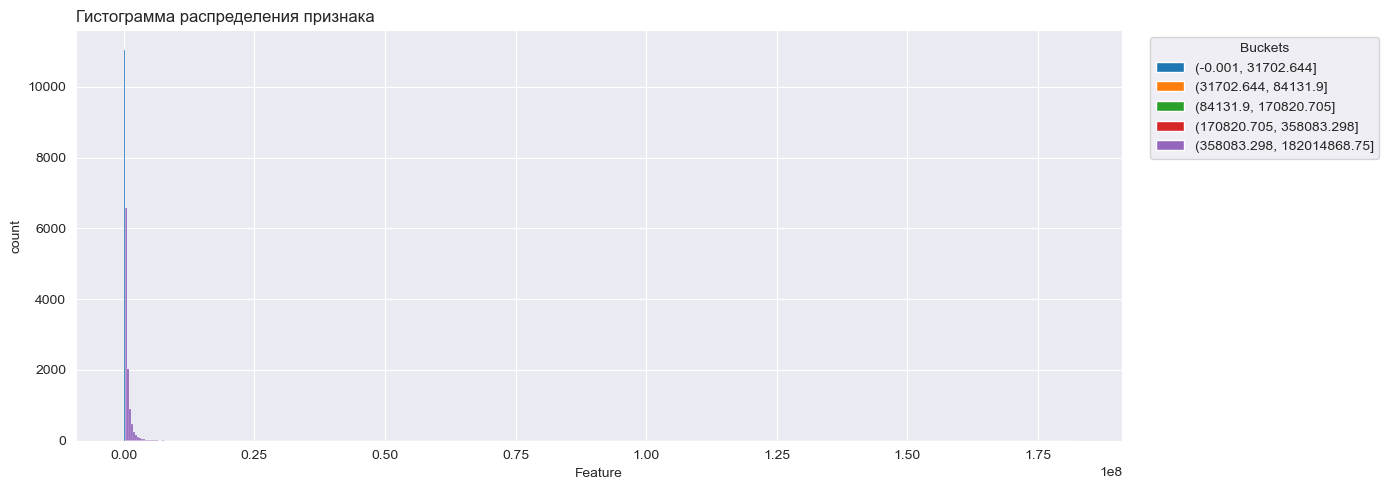

0.03232189037826294

===== max_limit =====
Удалено наблюдений: 0


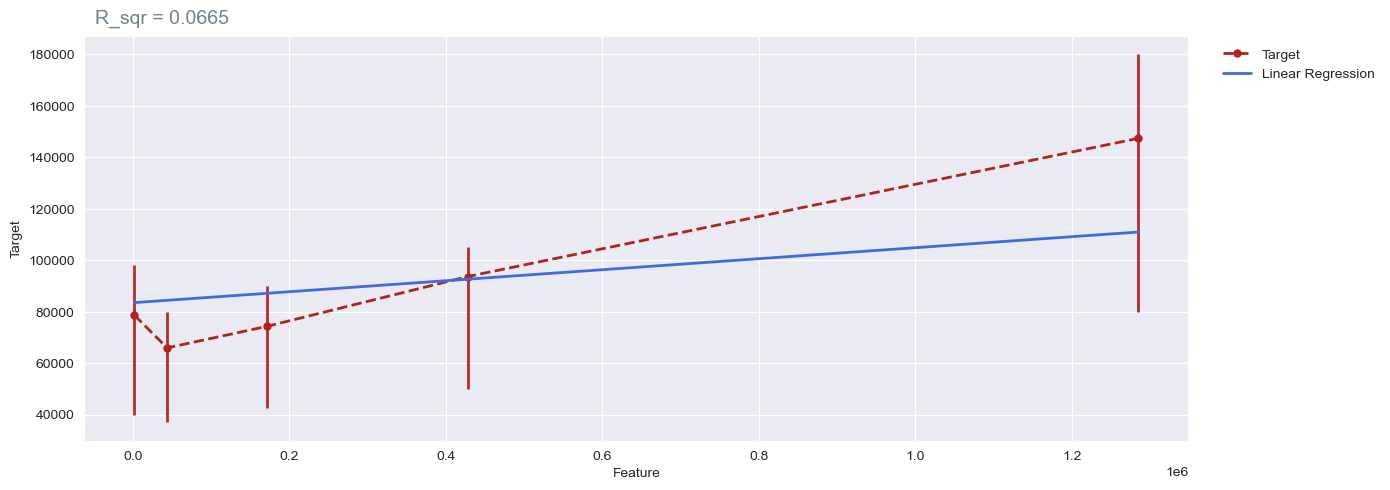

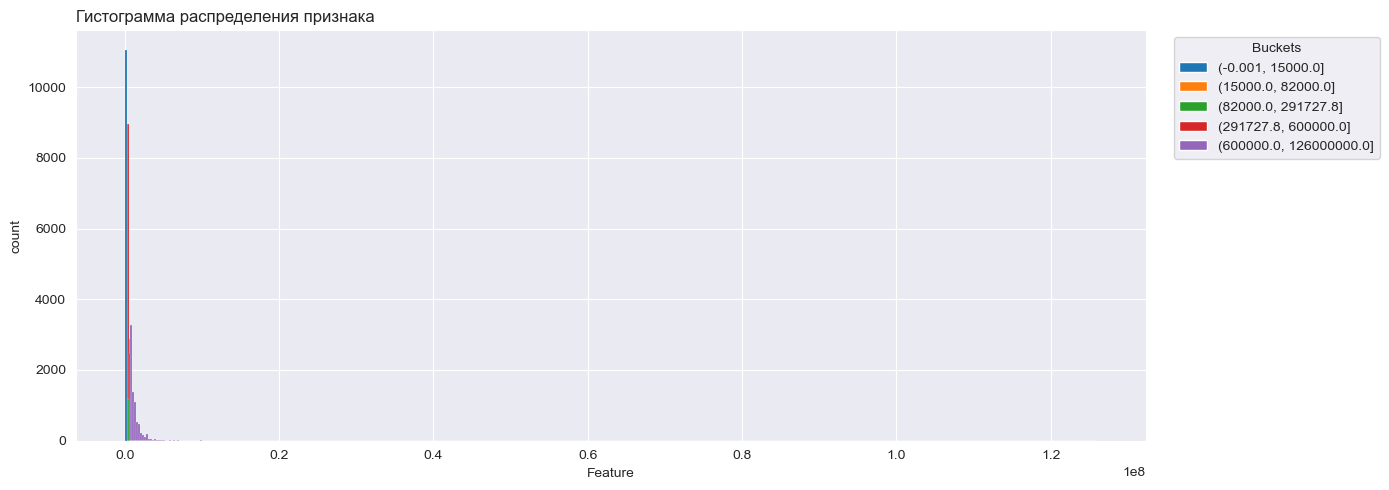

0.06646449036932922

===== credit_num =====
Удалено наблюдений: 0


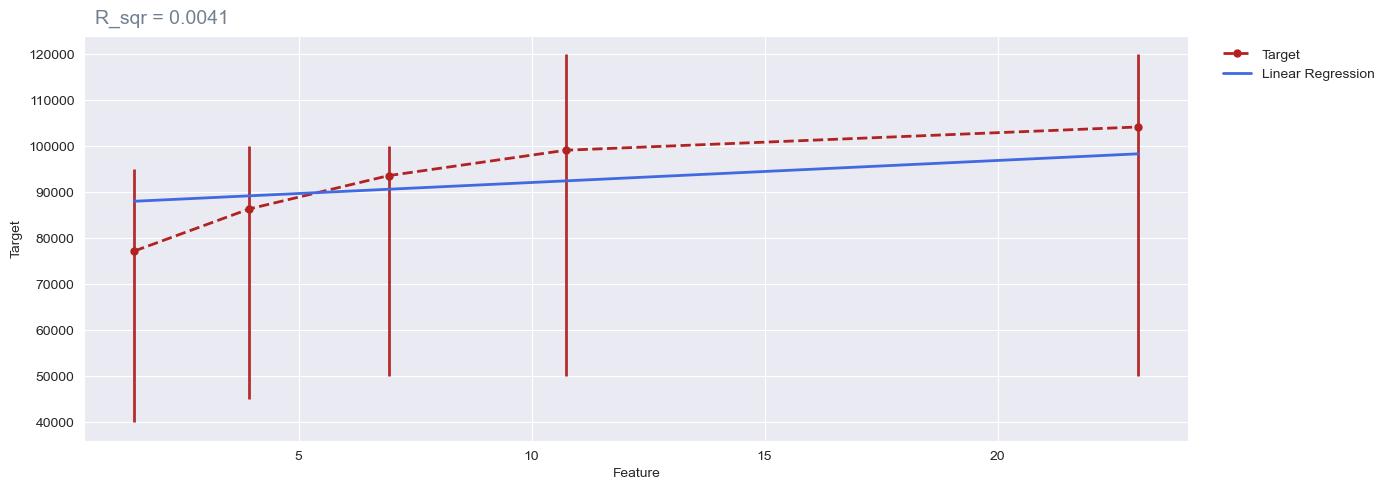

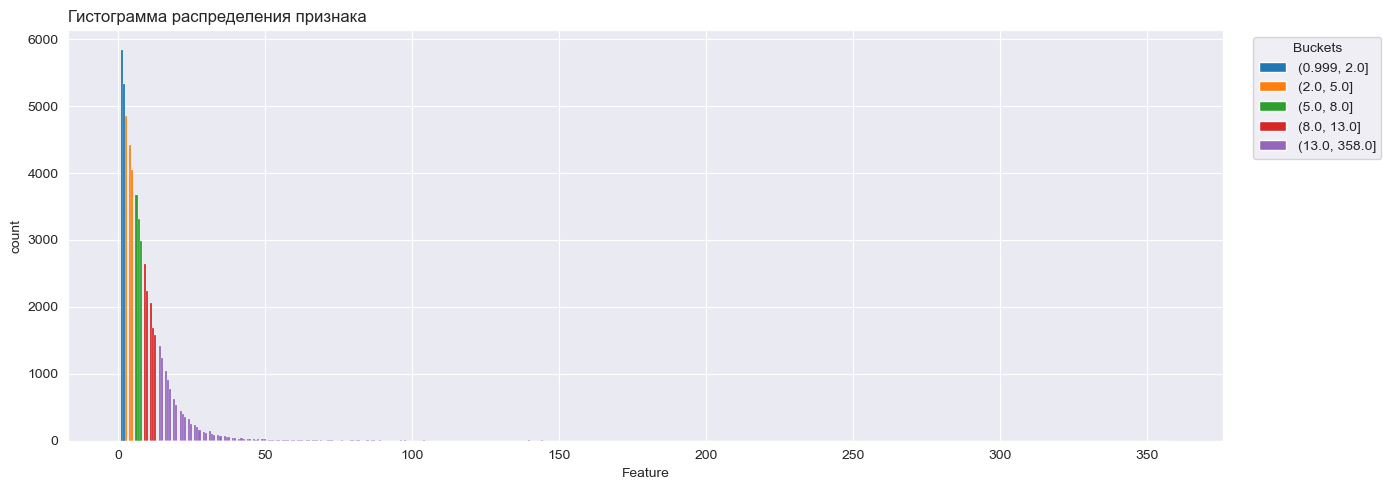

0.0041104062975301225

===== acc_num =====
Удалено наблюдений: 0


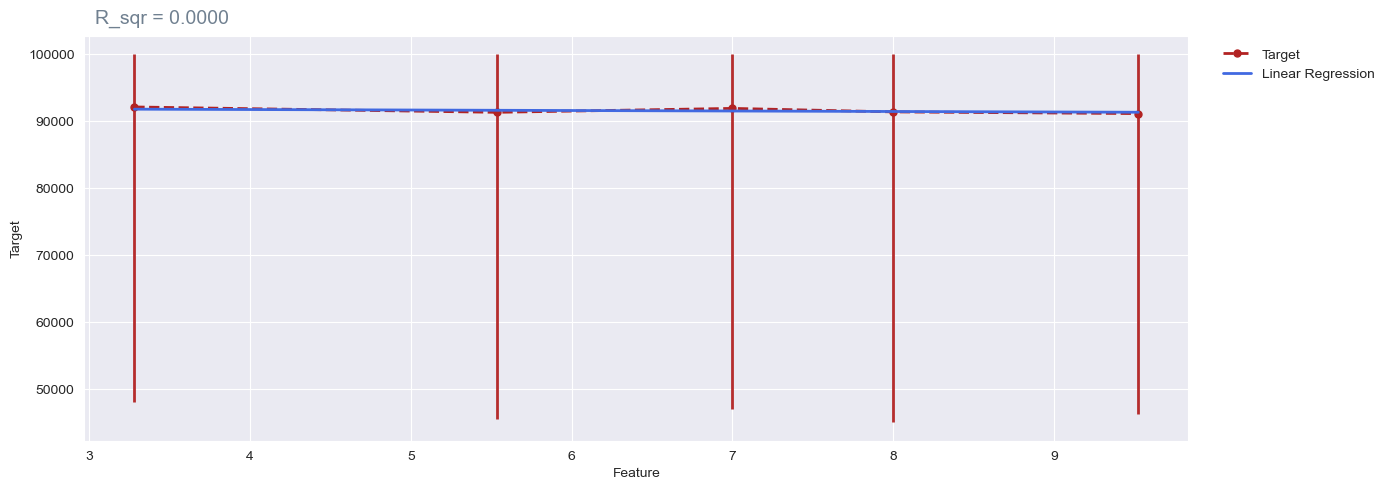

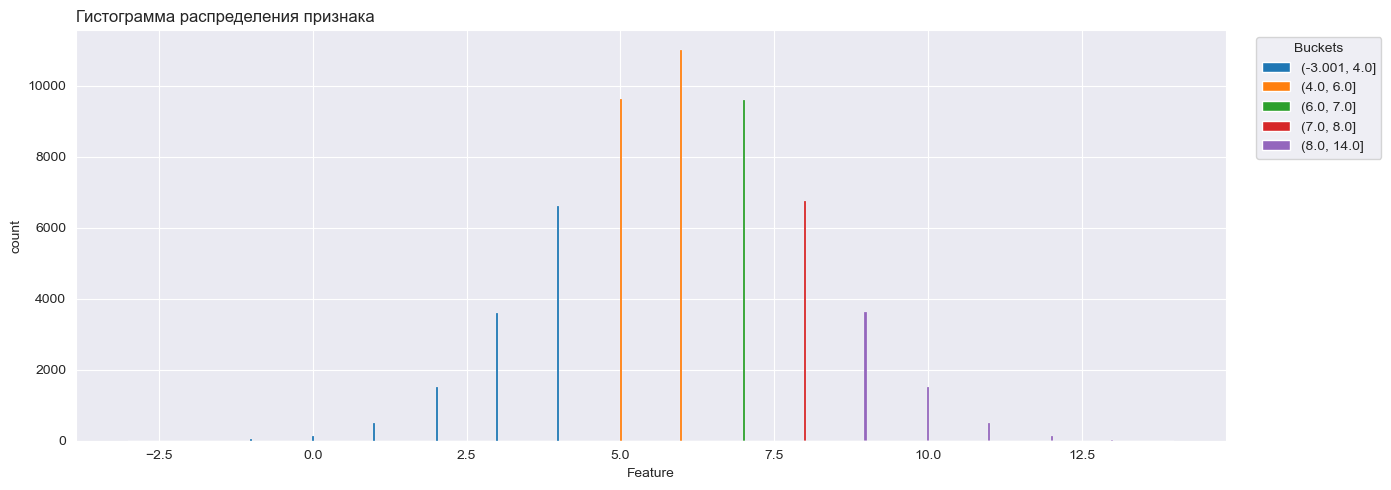

3.3824939490445516e-06

===== out_total_amt =====
Удалено наблюдений: 0


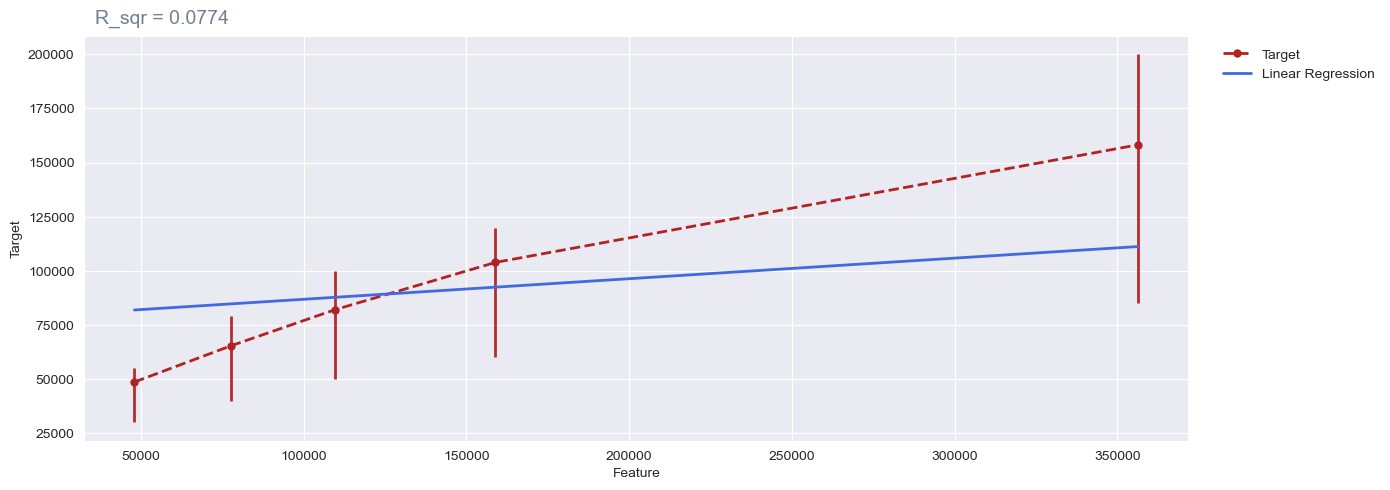

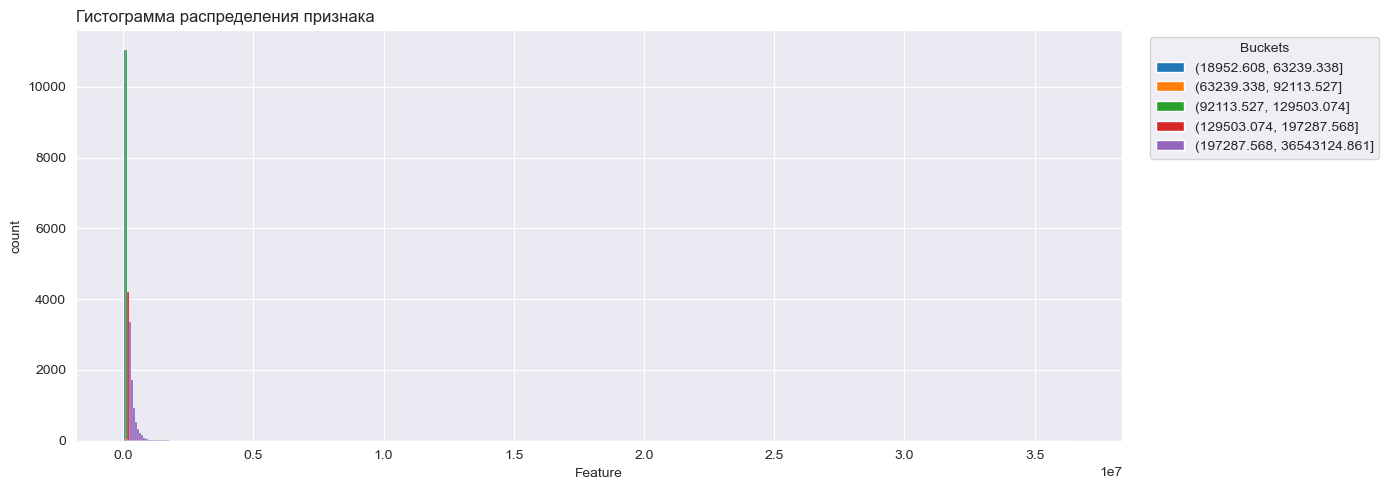

0.07737957663678607


In [137]:
for col in df.columns:
    if col not in ['id', 'income']:
        print(f'\n===== {col} =====')
        feature_line(df[col], df['income'], nbins=5)

#### Теперь линеаризуем

Попробую достаточно понятное монотонное преобразование для количественных признаков (особенно часто применяющихся к "денежным" признакам) - логарифмизацию. Бинарные признаки оставлю как есть (сохраняю интерпретацию, условный target-encoding бы ее несколько "испортил").

Почему так? Потому что почти все распределения имеют достаточно "тяжелые" хвосты, скошены в сторону. Логарифмизация хорошо с этим справится.

По совету в задании возраст линеаризую, используя несколько кусочно-заданных признаков.

In [139]:
# возраст

df['age_1'] = np.clip(df['age'], 18, 30)
df['age_2'] = np.clip(df['age'] - 30, 0, 20)
df['age_3'] = np.clip(df['age'] - 50, 0, None)

# логарифмы

df['log_in_total_amt'] = np.log1p(df['in_total_amt'])
df['log_avg_limit']   = np.log1p(df['avg_limit'])
df['log_job_salary']  = np.log1p(df['job_salary'])
df['log_out_total_amt'] = np.log1p(df['out_total_amt'])
df['log_max_limit']   = np.log1p(df['max_limit'])

# gender, car_own_flg оставляю как есть!

In [140]:
new_features = [
    'age_1', 'age_2', 'age_3',
    'log_in_total_amt',
    'log_avg_limit',
    'log_job_salary',
    'log_out_total_amt',
    'log_max_limit',
    'gender',
    'car_own_flg',
    'credit_num',
    'acc_num'
]


===== age_1 =====
Удалено наблюдений: 0


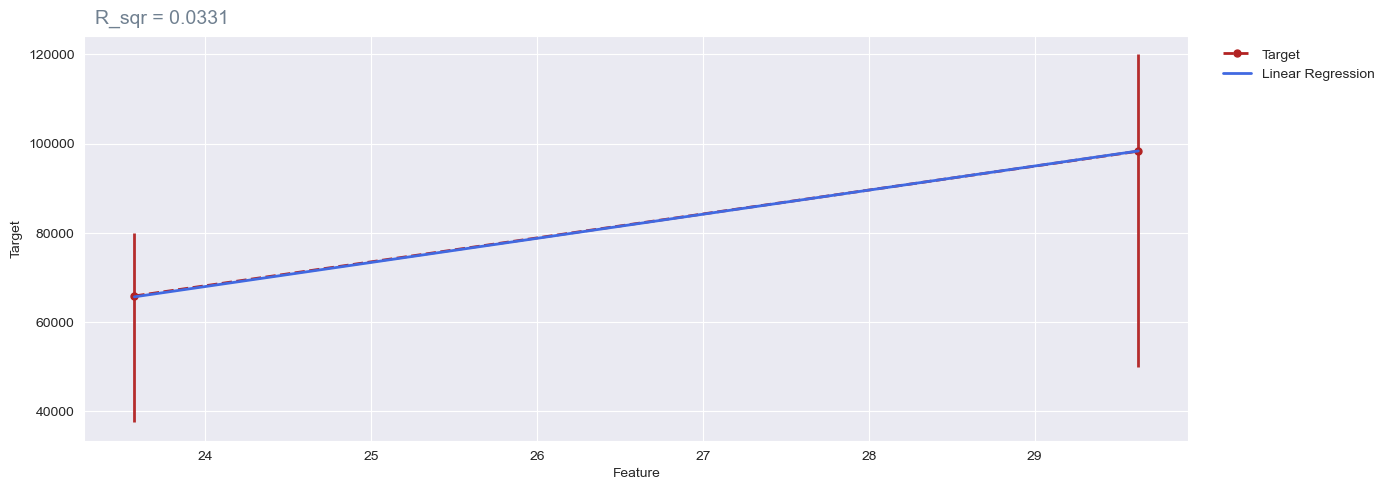

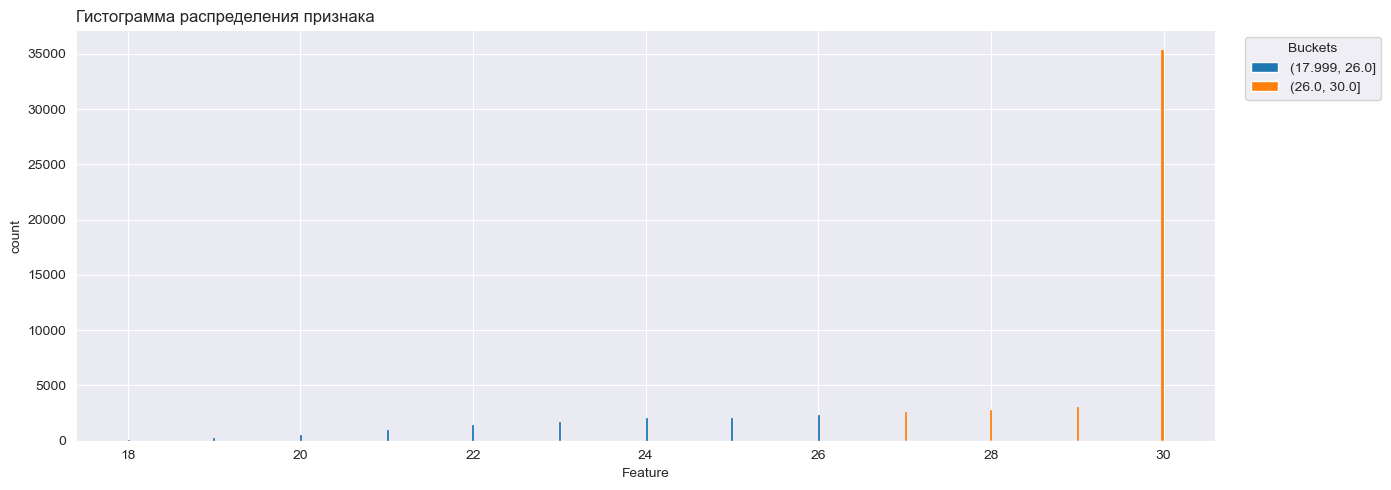

0.033078682086150835

===== age_2 =====
Удалено наблюдений: 0


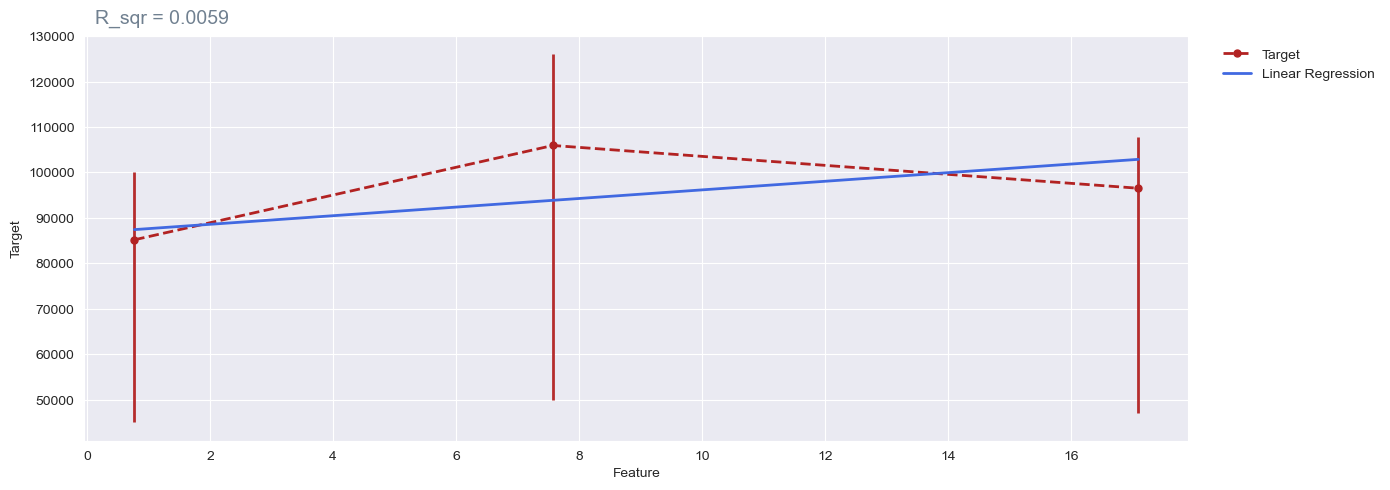

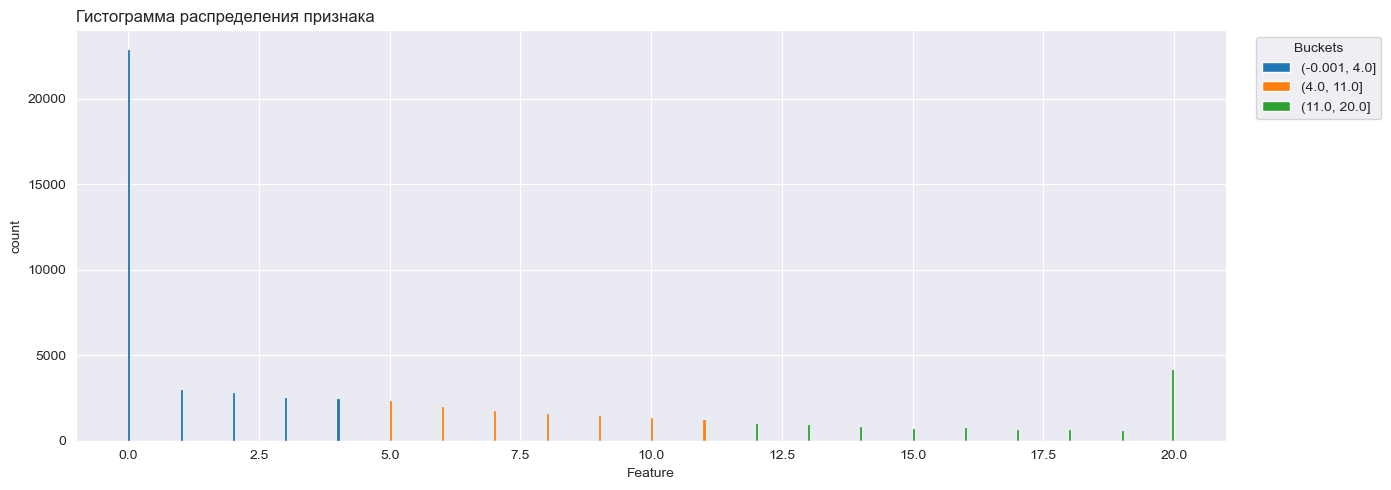

0.005877476155968786

===== age_3 =====
Удалено наблюдений: 0


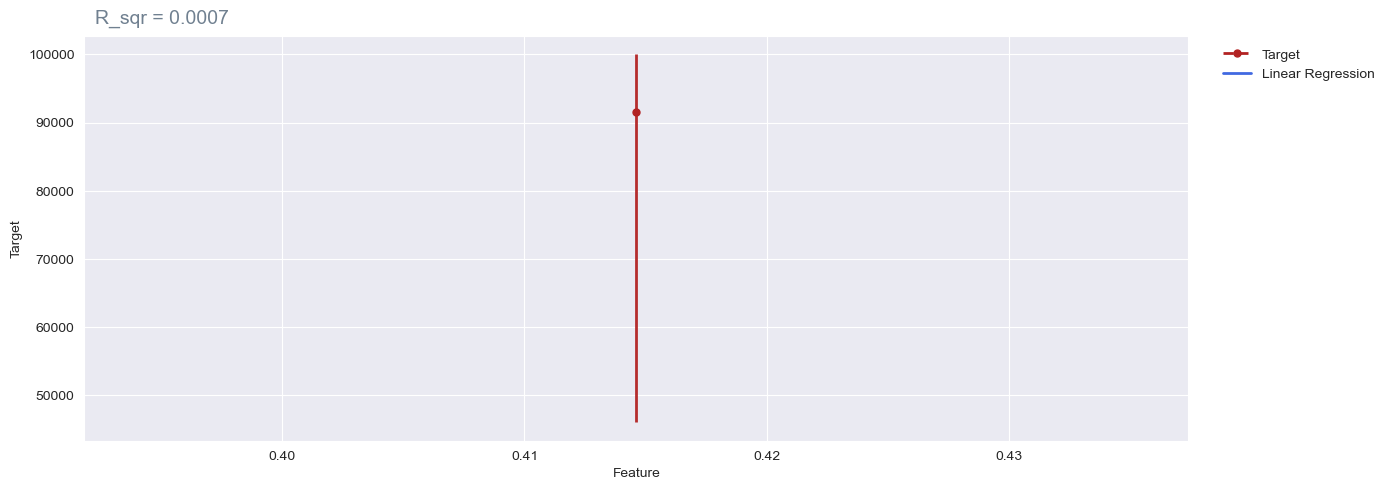

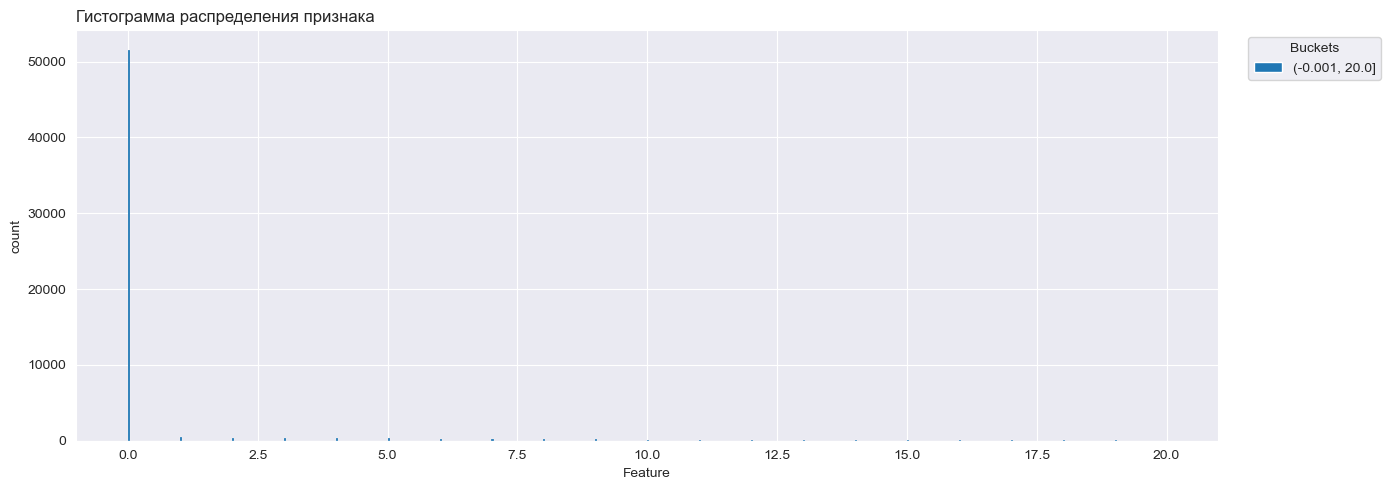

0.0007206462864907115

===== log_in_total_amt =====
Удалено наблюдений: 0


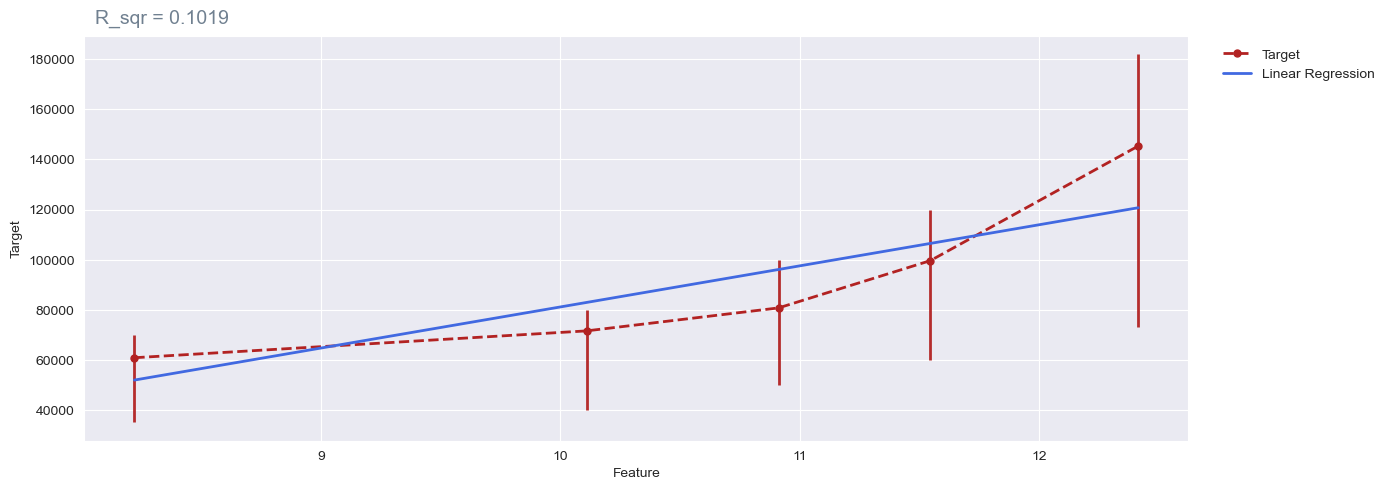

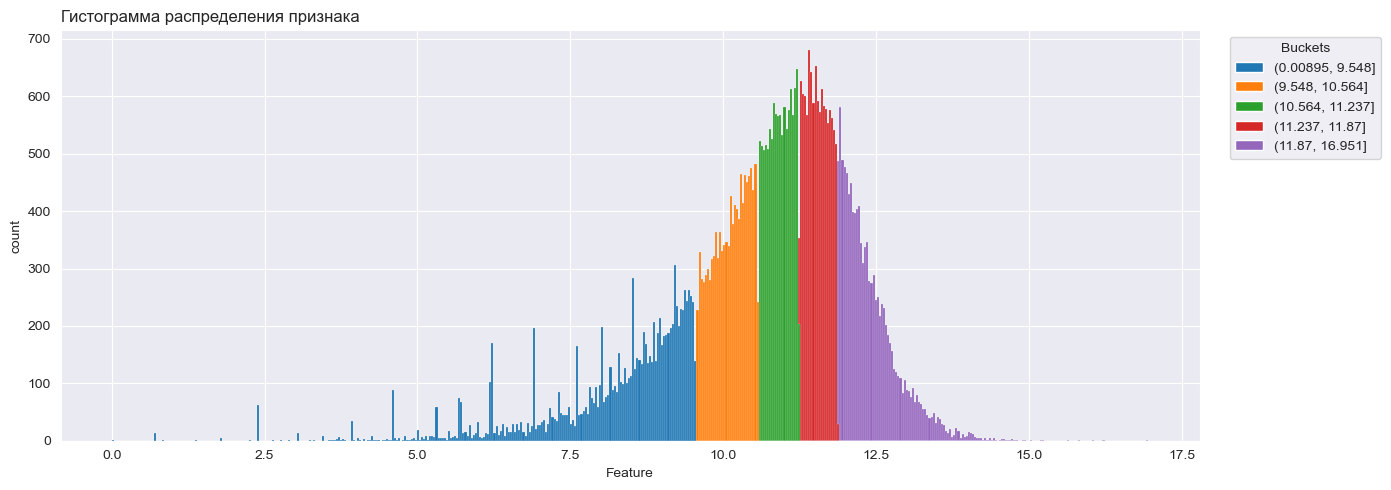

0.10187807309513708

===== log_avg_limit =====
Удалено наблюдений: 0


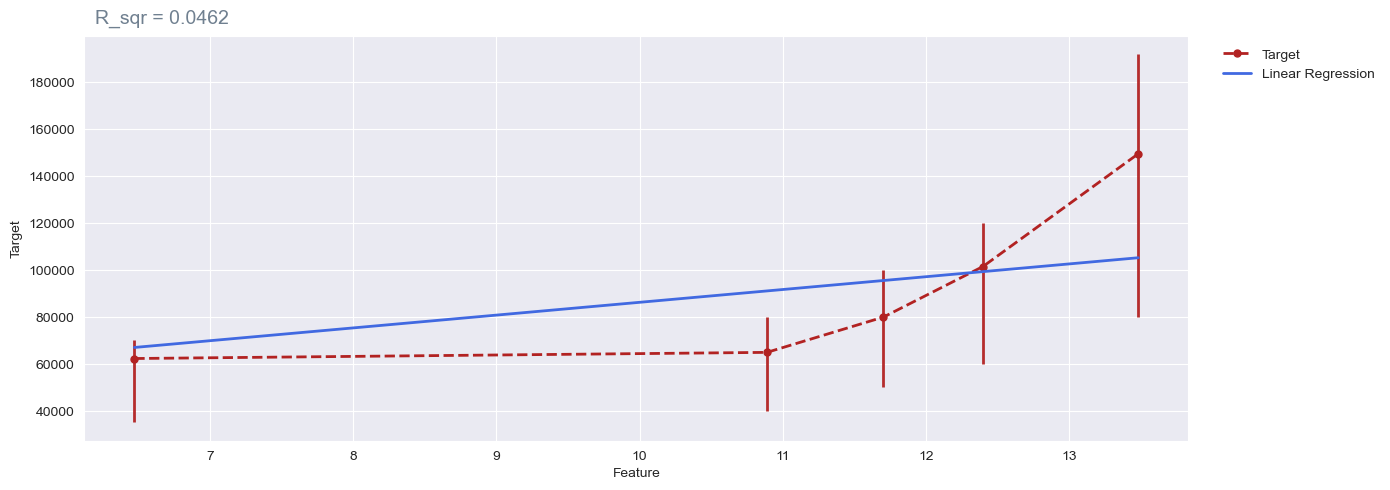

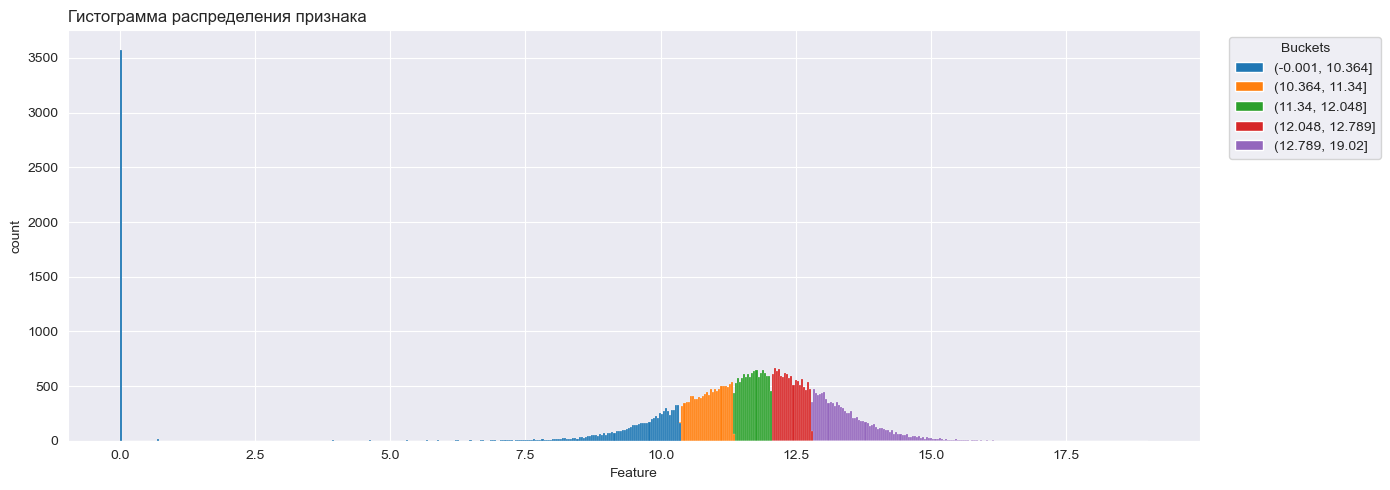

0.04620603303064641

===== log_job_salary =====
Удалено наблюдений: 0


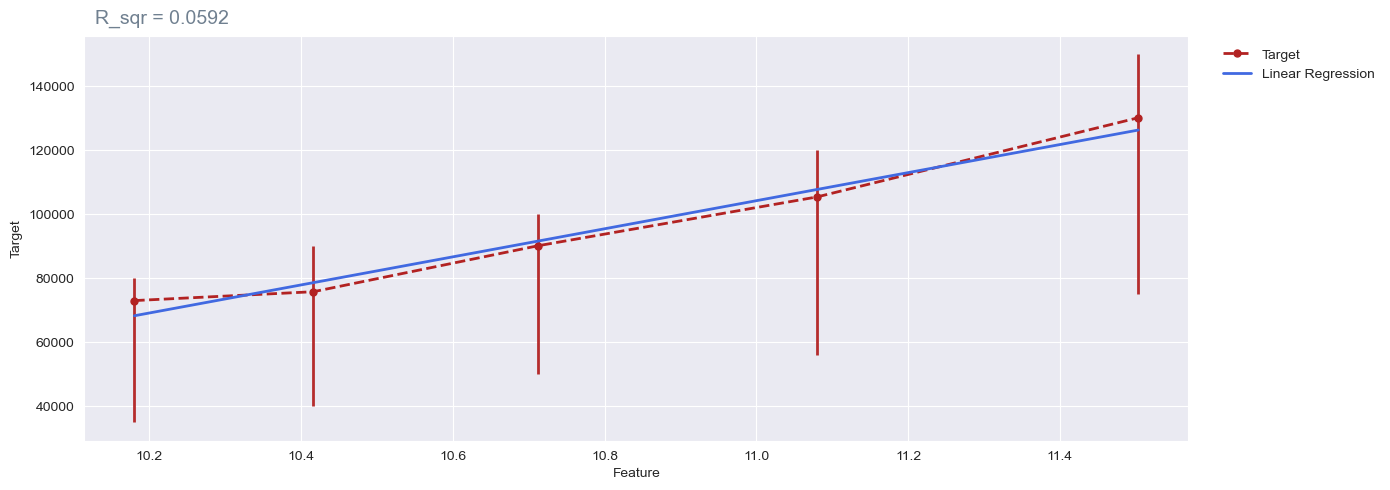

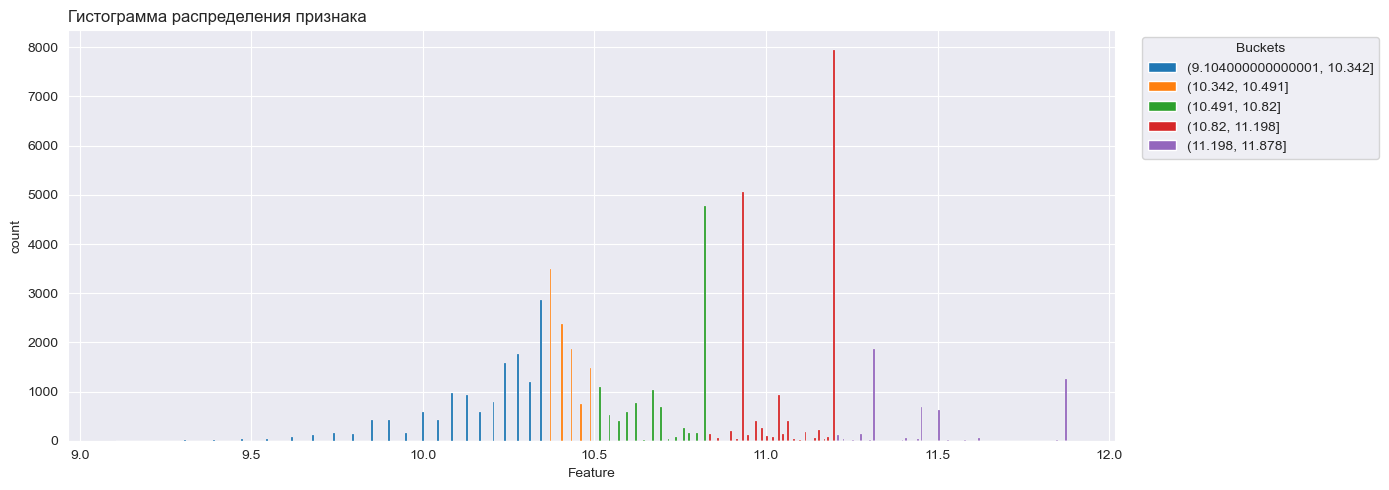

0.059187584420566264

===== log_out_total_amt =====
Удалено наблюдений: 0


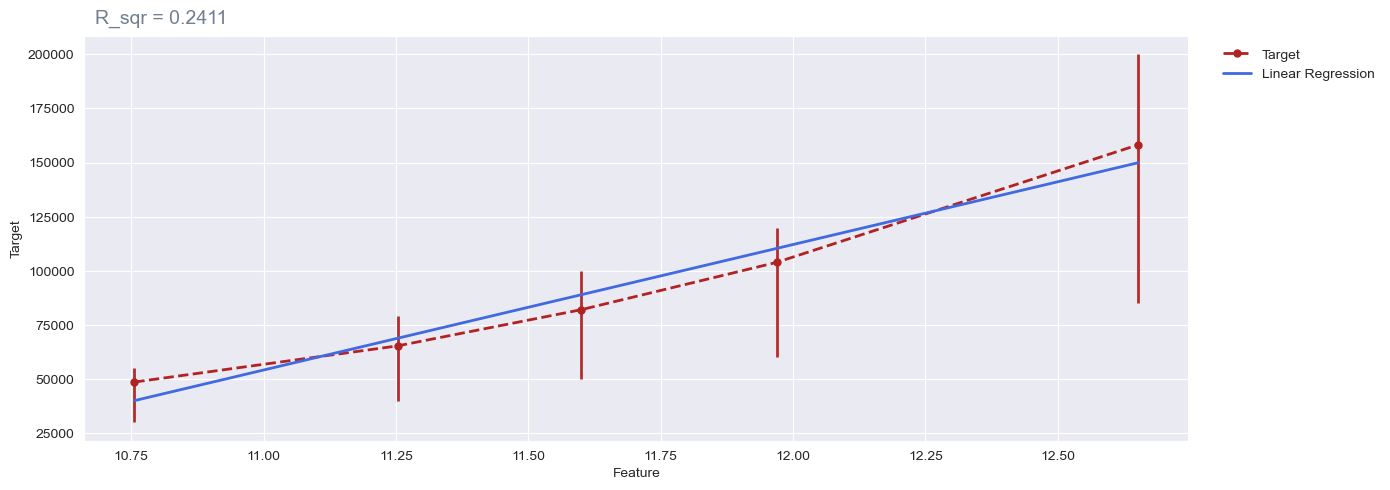

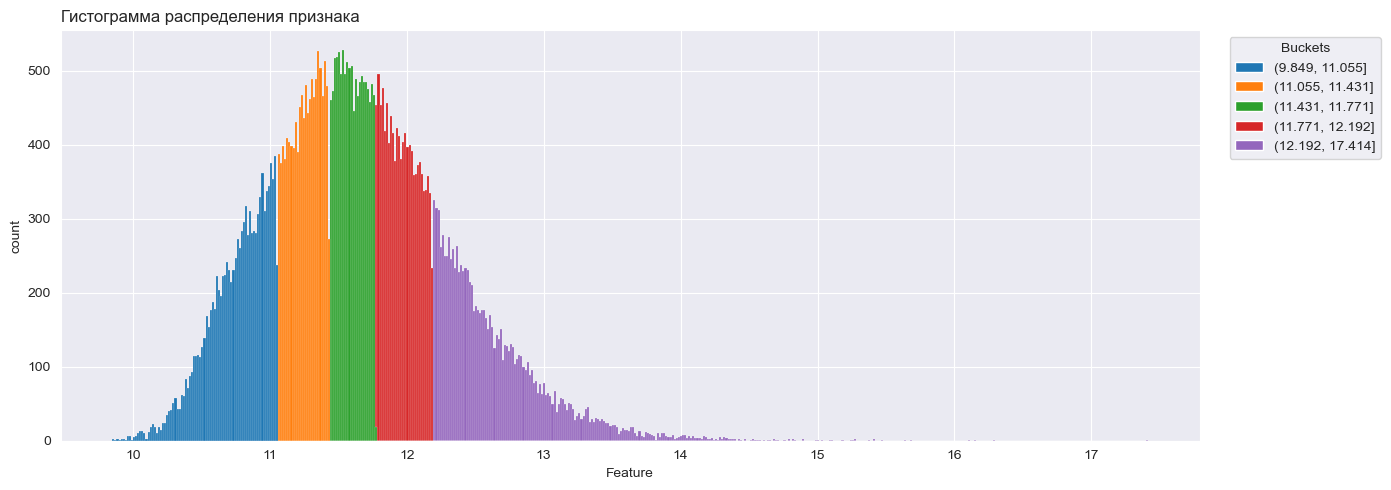

0.241079066737248

===== log_max_limit =====
Удалено наблюдений: 0


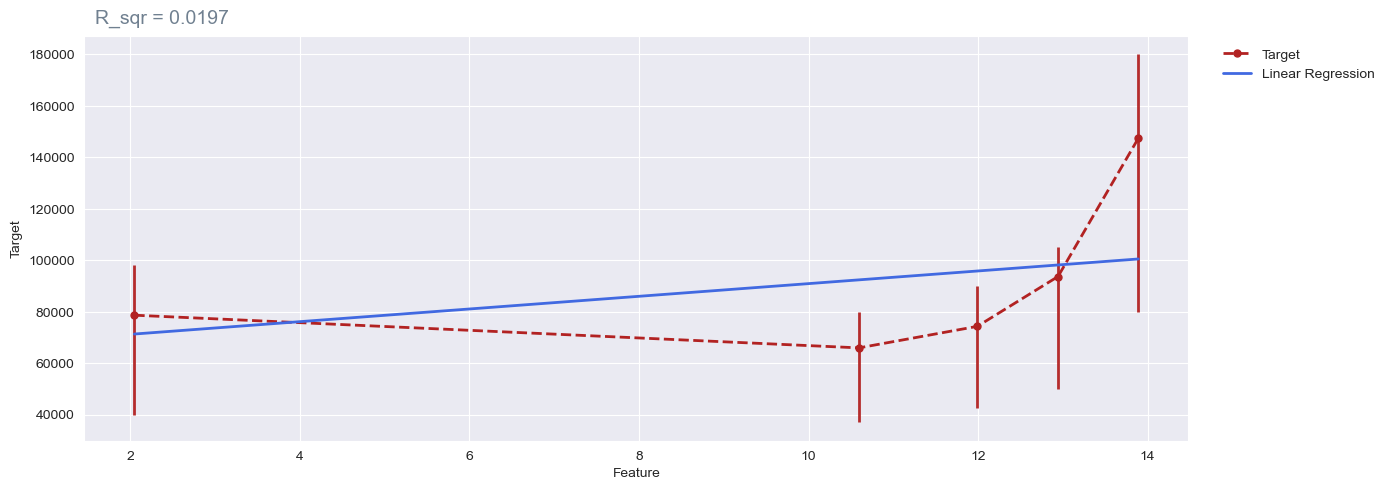

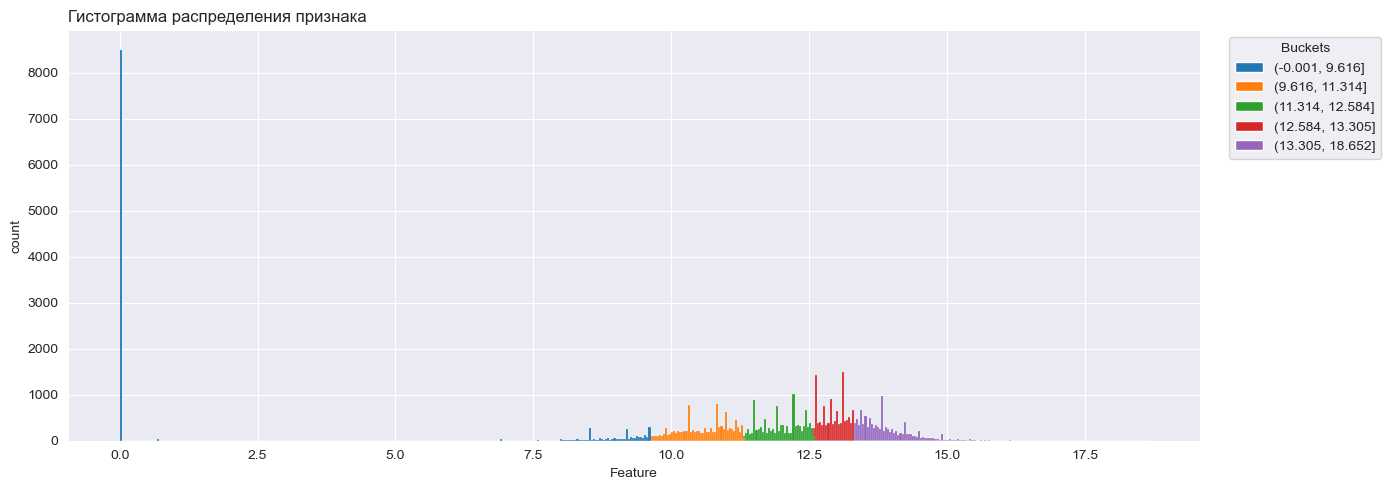

0.019740239600365417

===== gender =====
Удалено наблюдений: 0


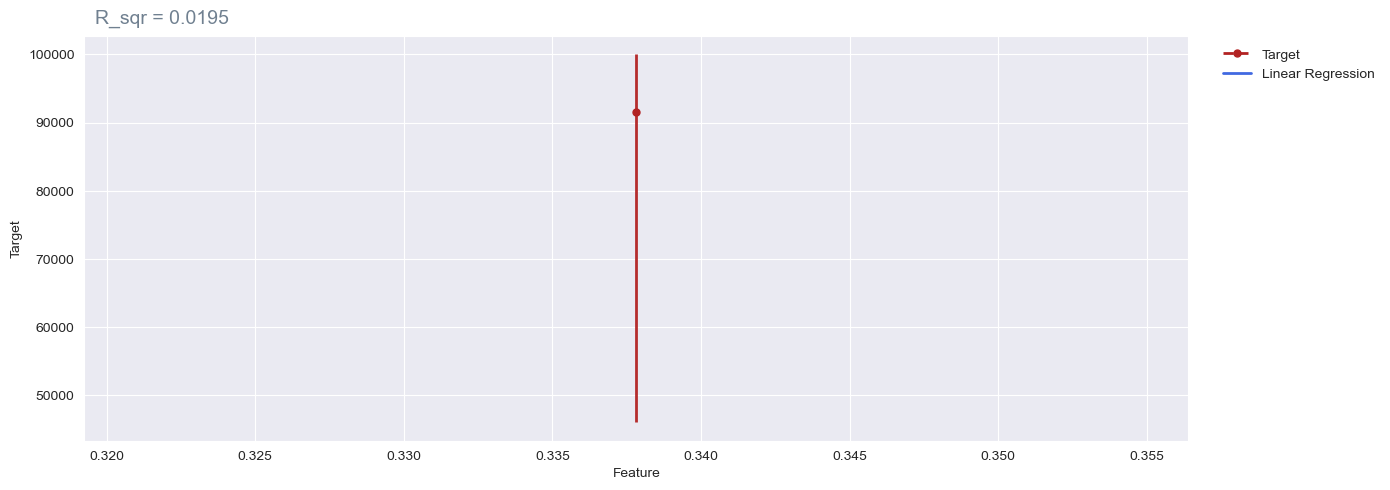

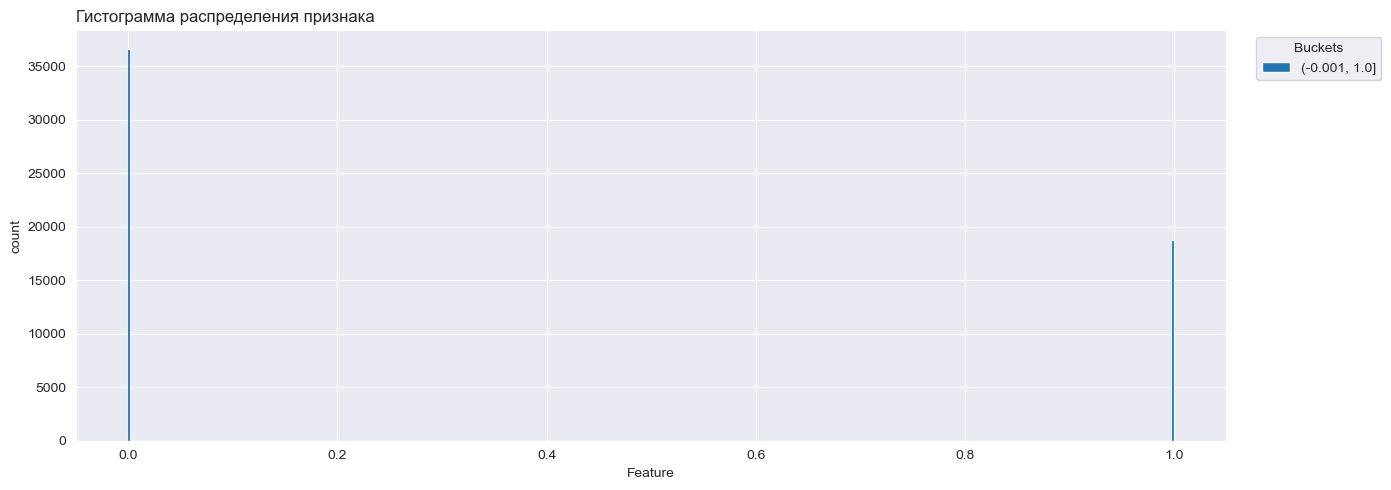

0.019531994819734888

===== car_own_flg =====
Удалено наблюдений: 0


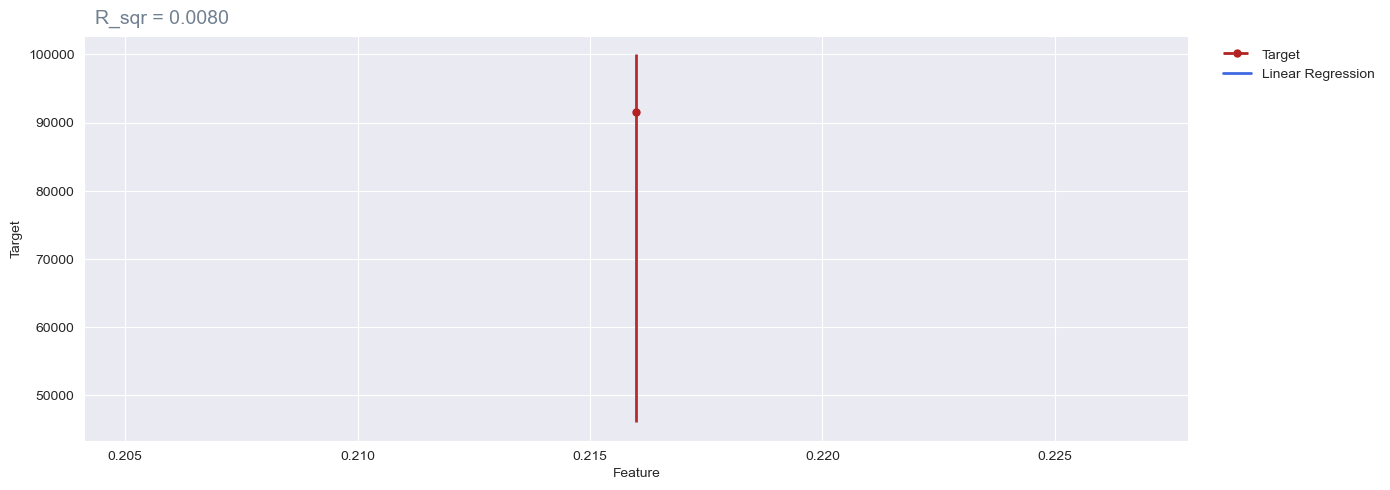

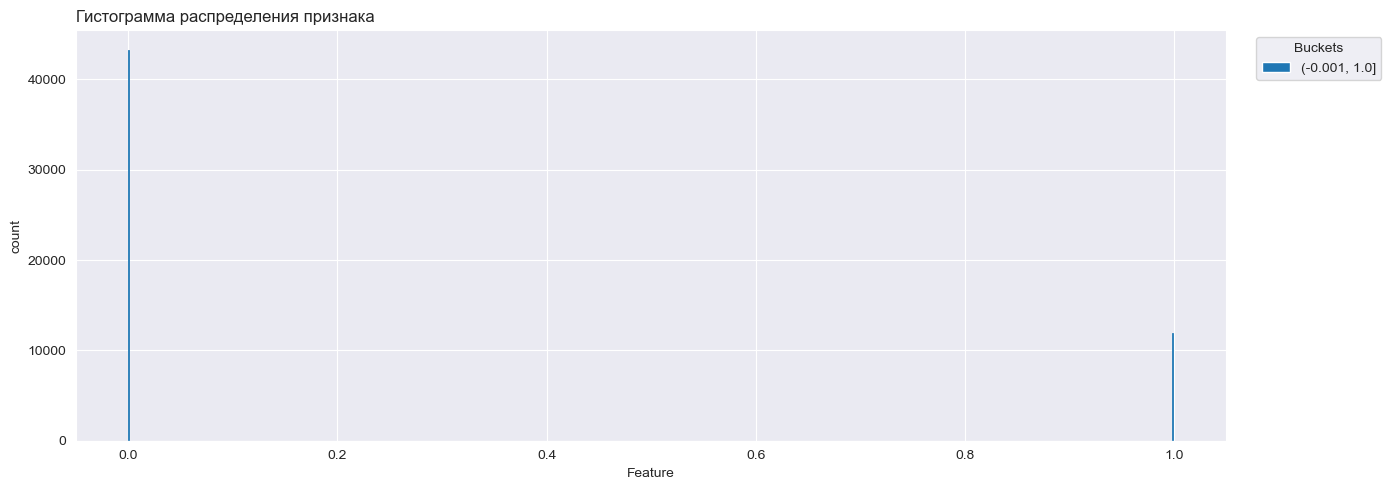

0.007982685857694127

===== credit_num =====
Удалено наблюдений: 0


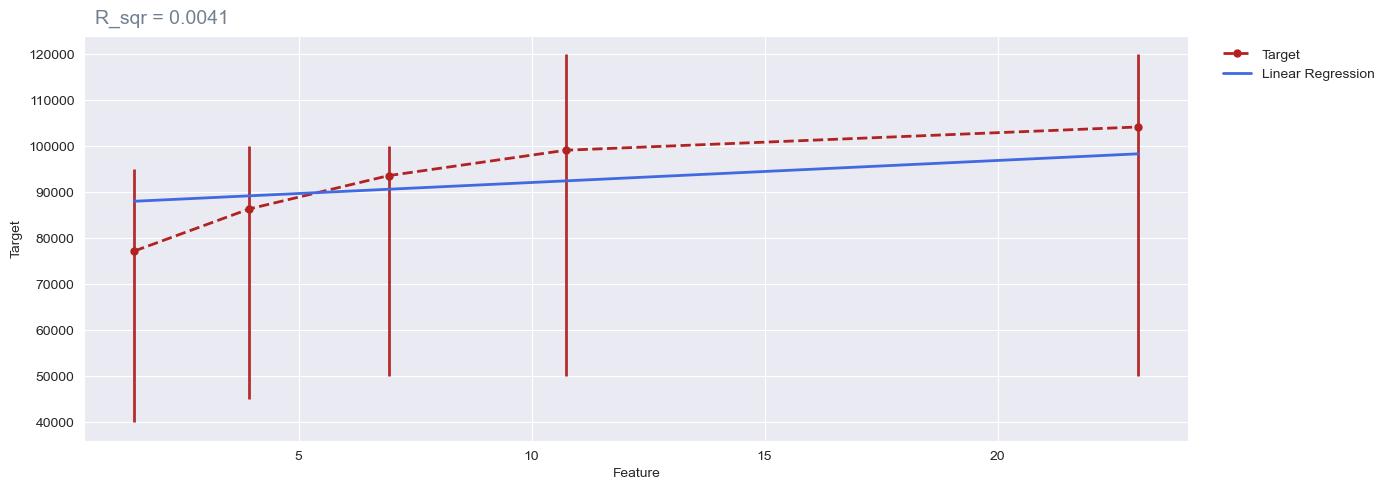

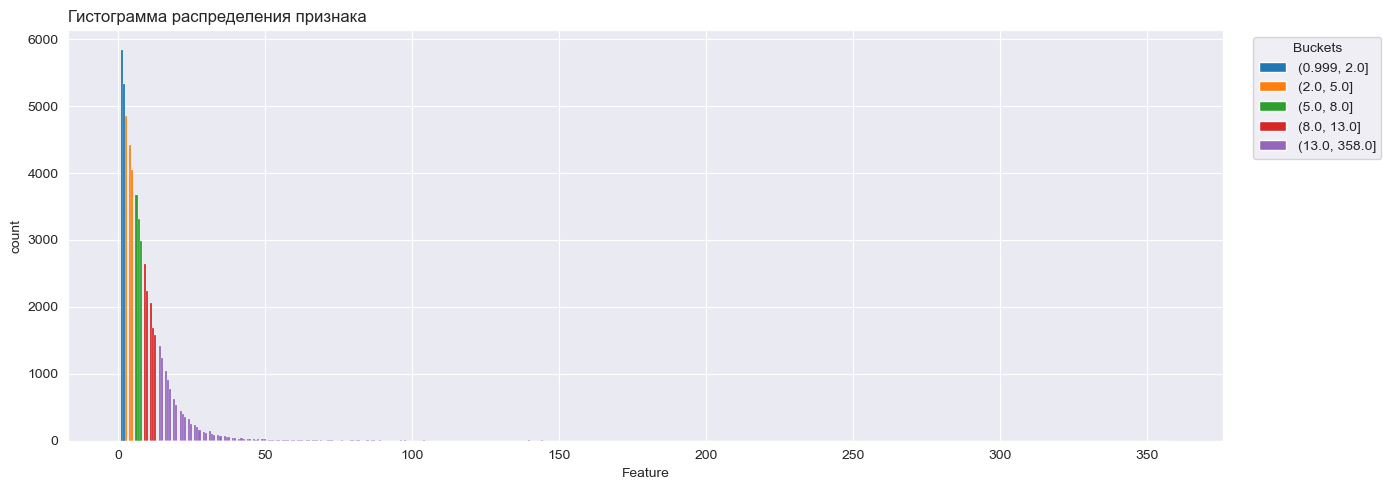

0.0041104062975301225

===== acc_num =====
Удалено наблюдений: 0


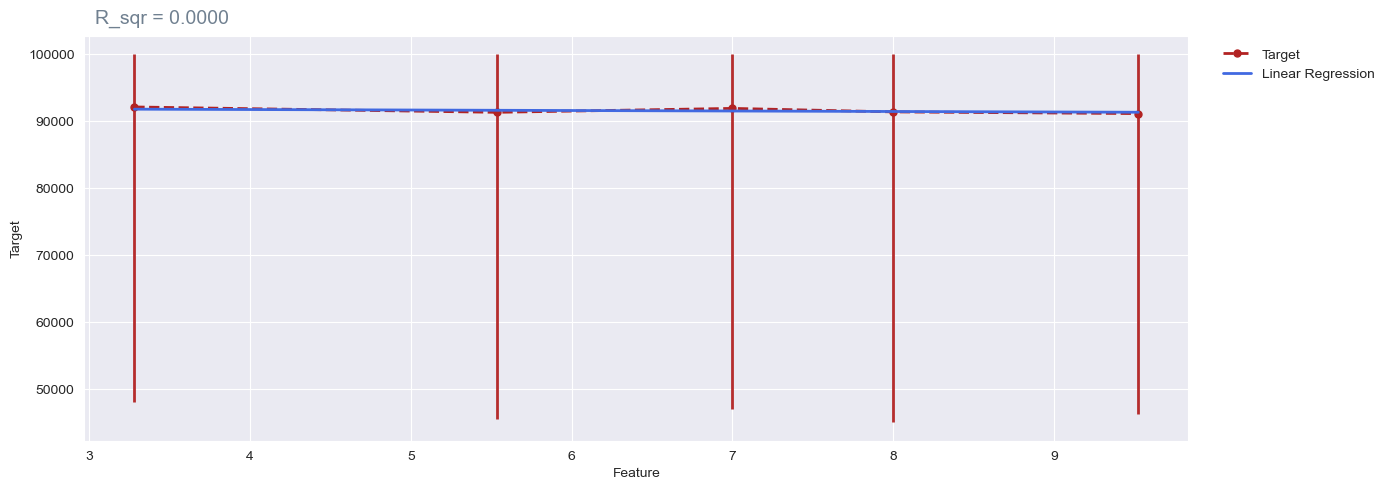

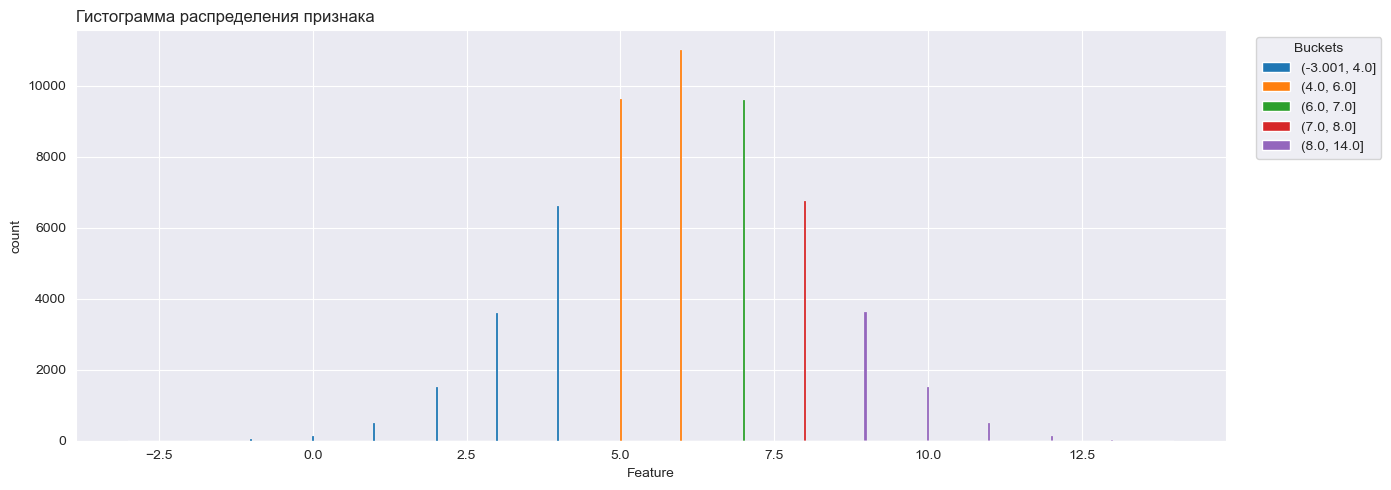

3.3824939490445516e-06


In [141]:
for f in new_features:
    print(f"\n===== {f} =====")
    feature_line(df[f], df['income'], nbins=5)

#### Решена ли проблема?

Там, где распределения были достаточно "скошенными" - решило!

<a id='task3'></a>
##### Задание 3 (1 балл)

Решить проблему гетероскедастичности для признака in_total_amt. Проверить остальные признаки.

Подсказка: обратите внимание на ограничения значений признака in_total_amt

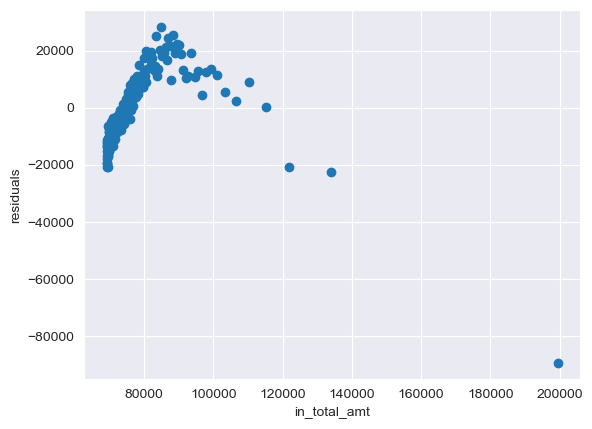

In [145]:
# функции из семинара:

def get_residuals(Y, Pred):
    '''Подсчет невязки Y - истинное значение таргета, Pred - предсказанное'''
    return Y - Pred

def check_homoscedacity(predictor,target,f_name):
    simple_model = LinearRegression()
    simple_model.fit(predictor.reshape(-1,1),target)
    predicts = simple_model.predict(predictor.reshape(-1,1))
    return (plt.scatter(predicts,get_residuals(target,predicts)))

def make_bucket(df,feature, n =  100):
    '''функция, бьющая на бакеты(по умолчанию 100 точек)'''
    return df.assign(bucket = np.ceil(df[feature].rank(pct = True) * n))


def plot_homoscedacity(predictor, target, predictor_name='feature'):
    df_tmp = pd.DataFrame({'predictor':predictor, 'target':target})
    return df_tmp.pipe(make_bucket,'predictor',200)\
                 .groupby(by = ['bucket']).mean()\
                 .pipe(lambda x:check_homoscedacity(np.array(x.predictor),np.array(x.target),predictor_name)) 


plot_homoscedacity(df.in_total_amt, np.exp(y_train),'in_total_amt')
plt.xlabel('in_total_amt')
plt.ylabel('residuals')
plt.show()

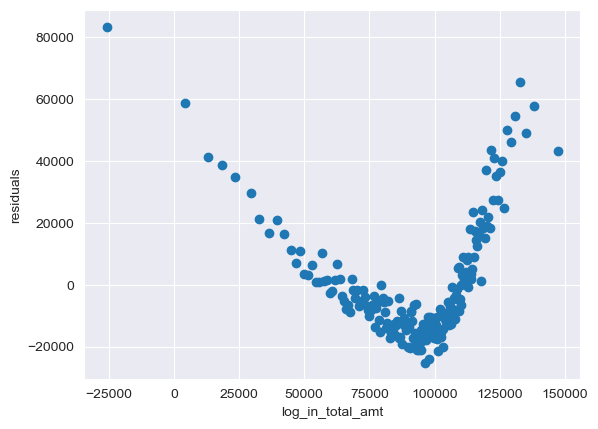

In [146]:
plot_homoscedacity(df.log_in_total_amt, df['income'],'log_in_total_amt')
plt.xlabel('log_in_total_amt')
plt.ylabel('residuals')
plt.show()


===== log_in_total_amt =====


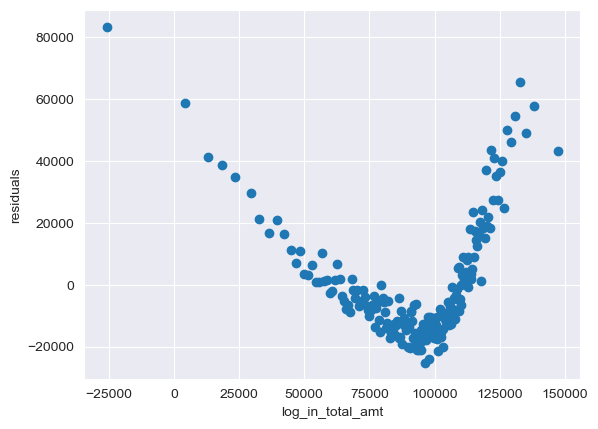


===== log_out_total_amt =====


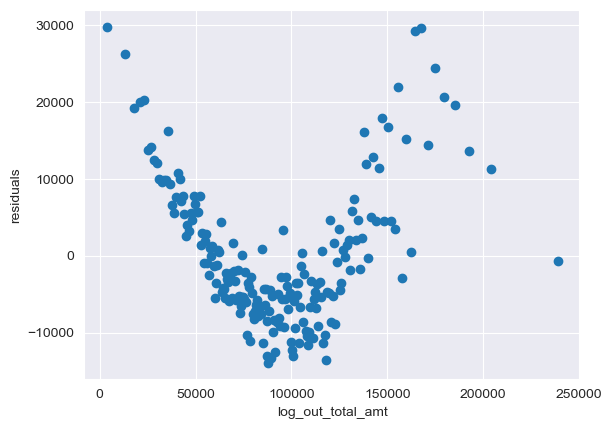


===== log_avg_limit =====


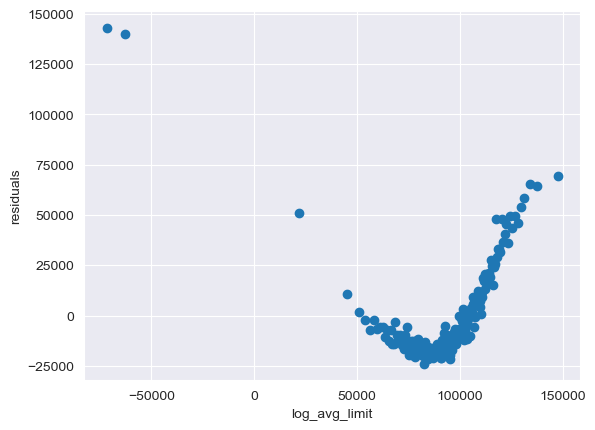


===== log_max_limit =====


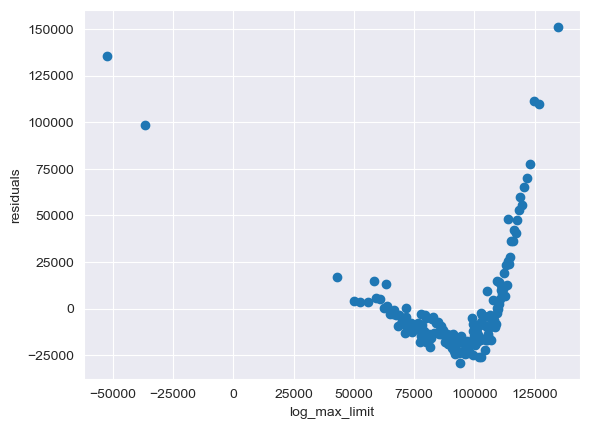


===== log_job_salary =====


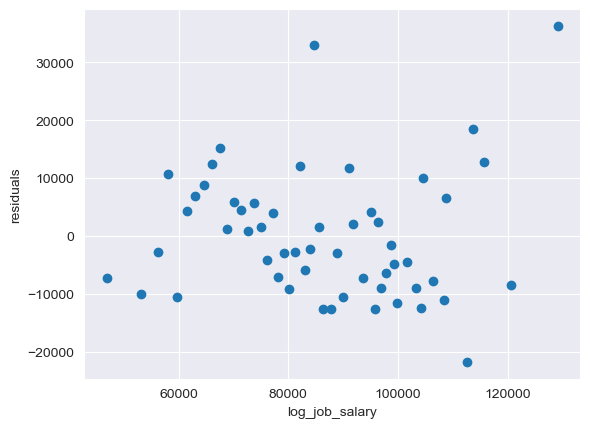


===== age_1 =====


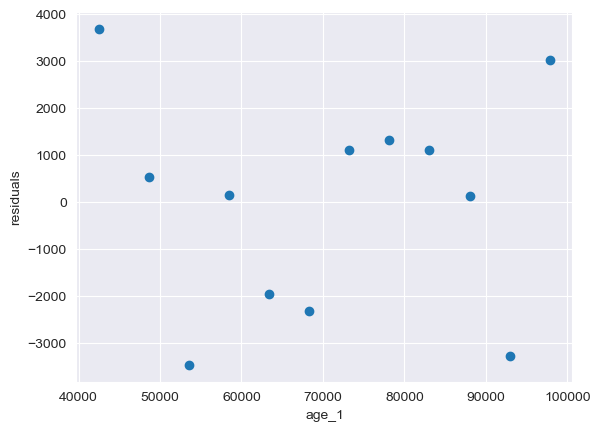


===== age_2 =====


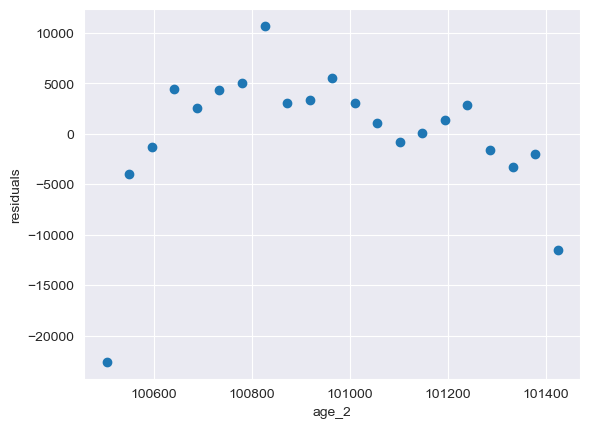


===== age_3 =====


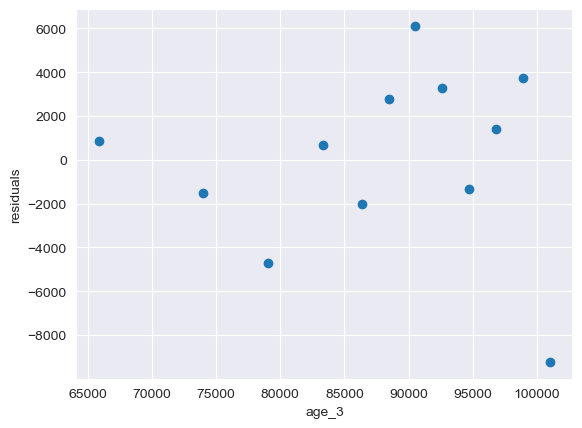


===== credit_num =====


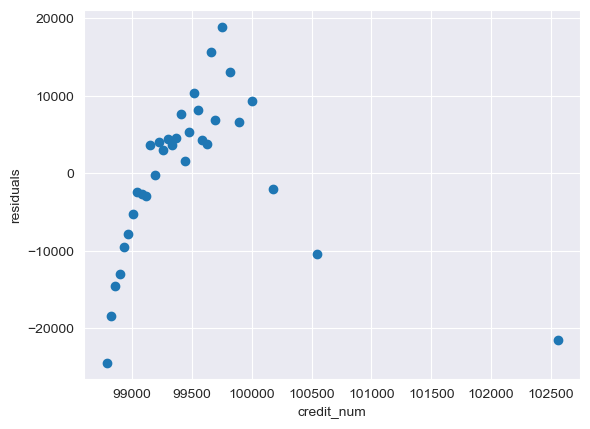


===== acc_num =====


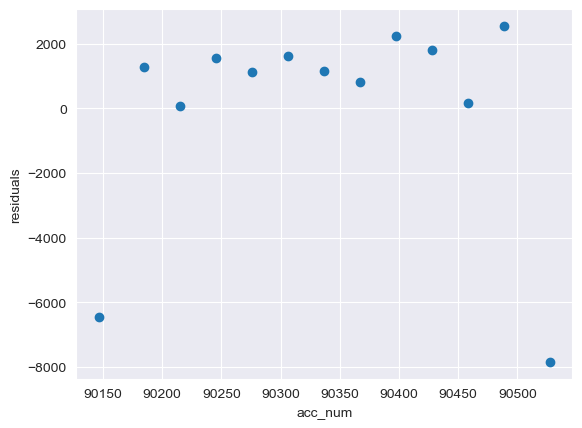

In [147]:
num_features = [
    'log_in_total_amt',
    'log_out_total_amt',
    'log_avg_limit',
    'log_max_limit',
    'log_job_salary',
    'age_1',
    'age_2',
    'age_3',
    'credit_num',
    'acc_num'
]

for f in num_features:
    print(f'\n===== {f} =====')
    plot_homoscedacity(df[f], df['income'], f)
    plt.xlabel(f)
    plt.ylabel('residuals')
    plt.show()

#### Выводы: задача отчасти выполнена, но как стандарт любого эконометрического исследования проще всего сразу использовать робастные стандартные ошибки, как минимум, простые в форме Уайта!

Также отмечу, что часть признаков потенциально стоит возвести в некоторую степень (использовать полиномиальные признаки); часть признаков сохраняет некоторую степень гетероскедастичности. Предлагаю решать проблему именно робастными ошибками (как делается в любом эконометрическом исследовании), а не попытками что-то "накрутить" в самих данных.

<a id='task4'></a>
##### Задание 4 (1 балл)

Вычислить VIF для всех признаков. Исключить признаки, линейно зависящие от остальных.

In [151]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [152]:
X = df[new_features].dropna()

vif_df = pd.DataFrame({
    'feature': new_features,
    'VIF': [round(variance_inflation_factor(X.values, i), 2)
            for i in range(len(new_features))]
}).set_index('feature')

vif_df

VIF
feature                  
age_1              143.28
age_2                2.74
age_3                1.39
log_in_total_amt    97.94
log_avg_limit       25.42
log_job_salary     520.67
log_out_total_amt  930.31
log_max_limit        9.91
gender               1.55
car_own_flg          1.31
credit_num           1.92
acc_num              9.73

#### Дополнительно построю корреляционную матрицу:

C:\Users\smirn\AppData\Local\Temp\ipykernel_22032\1383140287.py:1: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


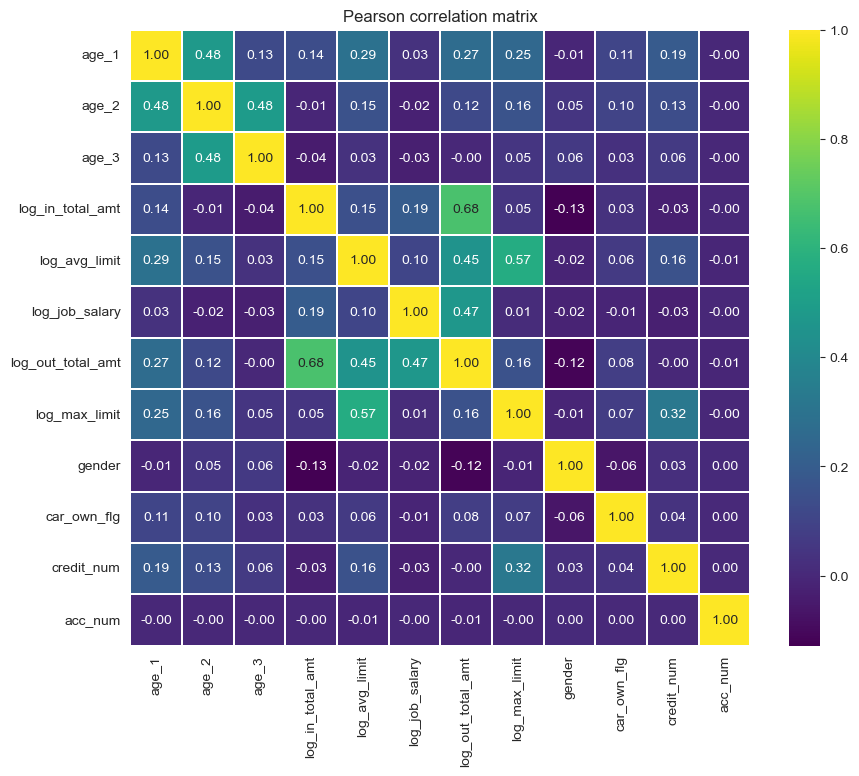

In [154]:
from scipy.stats.stats import pearsonr   
import seaborn as sns

numeric = new_features

# корреляционная матрица
cor = df.loc[:, numeric].corr(method='pearson')

plt.figure(figsize=(10, 8))
cm = plt.cm.viridis
sns.heatmap(cor, cmap=cm, linewidths=0.1, linecolor='white', annot=True, fmt=".2f")
plt.title("Pearson correlation matrix")
plt.show()

#### Выводы: лично я не считаю VIF достаточно "надежным" показателем. Проверка и решение проблемы мультиколлинеарности может решаться на усмотрение исследователя и, соответственно, теми методами, которые он выбрал. Можно еще посмотреть, как близок det(X'X) к нулю, посчитать число обусловленности матрицы и так далее. Предлагаю сделать выводы на основе матрицы корреляций и VIF совместно. Признаки буду убирать итеративно - т. е. каждый раз пересчитывая VIF.

In [156]:
new_features = [
    'log_in_total_amt',
    # 'log_out_total_amt', ####
    'log_avg_limit',
    'log_max_limit',
    'log_job_salary',
    'age_1',
    'age_2',
    'age_3',
    'credit_num',
    'acc_num'
]

In [157]:
X = df[new_features].dropna()

vif_df = pd.DataFrame({
    'feature': new_features,
    'VIF': [round(variance_inflation_factor(X.values, i), 2)
            for i in range(len(new_features))]
}).set_index('feature')

vif_df

VIF
feature                 
log_in_total_amt   50.77
log_avg_limit      20.30
log_max_limit       9.71
log_job_salary    146.89
age_1             136.25
age_2               2.72
age_3               1.39
credit_num          1.91
acc_num             9.72

C:\Users\smirn\AppData\Local\Temp\ipykernel_22032\1383140287.py:1: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


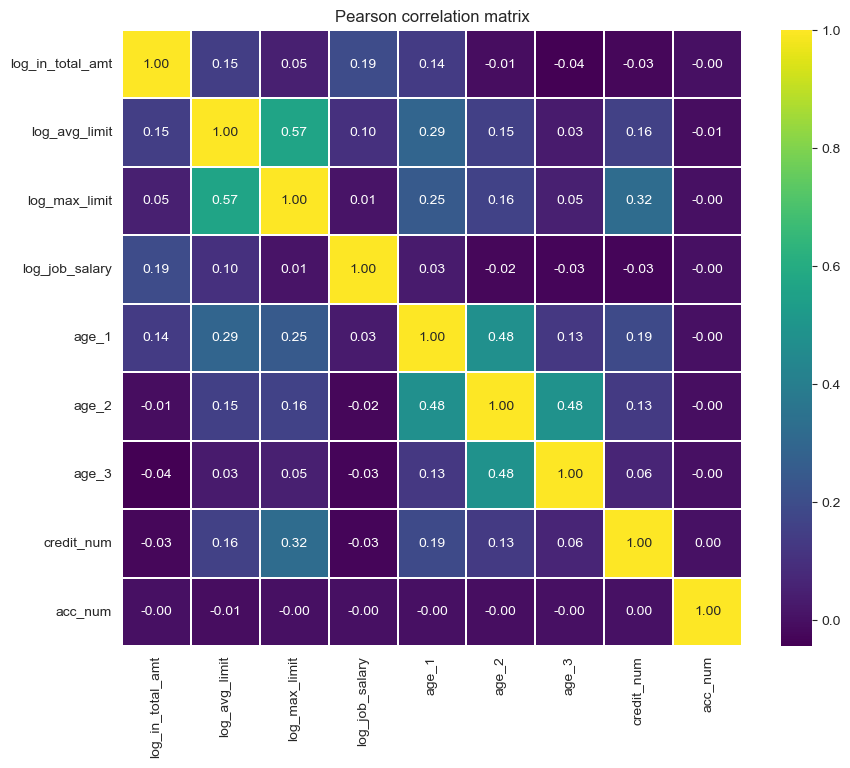

In [158]:
from scipy.stats.stats import pearsonr   
import seaborn as sns

numeric = new_features

# корреляционная матрица
cor = df.loc[:, numeric].corr(method='pearson')

plt.figure(figsize=(10, 8))
cm = plt.cm.viridis
sns.heatmap(cor, cmap=cm, linewidths=0.1, linecolor='white', annot=True, fmt=".2f")
plt.title("Pearson correlation matrix")
plt.show()

In [159]:
# new_features = [
#     'log_in_total_amt',
#     # 'log_out_total_amt', ###
#     'log_avg_limit',
#     'log_max_limit',
#     'log_job_salary', ###
#     'age_1',
#     'age_2',
#     'age_3',
#     'credit_num',
#     'acc_num'
# ]

In [160]:
# X = df[new_features].dropna()

# vif_df = pd.DataFrame({
#     'feature': new_features,
#     'VIF': [round(variance_inflation_factor(X.values, i), 2)
#             for i in range(len(new_features))]
# }).set_index('feature')

# vif_df

In [161]:
# from scipy.stats.stats import pearsonr   
# import seaborn as sns

# numeric = new_features

# # корреляционная матрица
# cor = df.loc[:, numeric].corr(method='pearson')

# plt.figure(figsize=(10, 8))
# cm = plt.cm.viridis
# sns.heatmap(cor, cmap=cm, linewidths=0.1, linecolor='white', annot=True, fmt=".2f")
# plt.title("Pearson correlation matrix")
# plt.show()

#### Вывод: считаю проблему решенной. Не вижу смысла продолжать работать с age, т. к. мультиколлинеарность между этими фичами приемлемая. Ровно как и с прочими признаками.

<a id='task5'></a>
##### Задание 5 (2 балла)

Построить модель линейной регрессии на рассмотренных и остальных признаках. Не забудьте проверить нормальность остатков вашей модели. 

Вычислить метрику $R^2$ и сравнить с baseline.

### ВОПРОС: а для чего проверять нормальность остатков? Нормальность \epsilon не является предпосылкой ГМ для получения BLUE-оценок. Или идея в том,что важно проверять гипотезы в проде?.. Этот момент в лекции подсвечен достаточно странно.

P. S. за baseline считаю последнюю модель из семинара.

R2_train: 0.2627
R2_test: 0.2741

In [ ]:
Дублирую импорты для чистоты

In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[new_features], df['income'], test_size=0.3, shuffle=False) # shuffle=False - делим по времени

In [167]:
X_train

log_in_total_amt  log_avg_limit  log_max_limit  log_job_salary  age_1  \
0              9.001078       9.460943      10.080084       10.373522   22.0   
1             10.150387      10.180456      10.110989       10.373522   26.0   
2             12.283461       9.124509      10.434086       10.545368   25.0   
3             11.571210      10.378277      10.062711       10.596660   30.0   
4             11.539308      10.558271      13.279369        9.741027   23.0   
...                 ...            ...            ...             ...    ...   
38635         10.918850      12.551568      12.206078       11.198228   30.0   
38636         12.122221      12.500673       0.000000       11.877576   24.0   
38637          8.400135      11.495976      12.611541       10.757924   30.0   
38638         11.354927      11.332509      11.241156       11.198228   30.0   
38639         12.029252      13.137070      14.176626       11.198228   30.0   

       age_2  age_3  credit_num  acc_num  
0        0.0    0.0           7      9.0  
1        0.0    0.0           3      7.0  
2        0.0    0.0          14      3.0  
3        6.0    0.0           4      6.0  
4        0.0    0.0           9      7.0  
...      ...    ...         ...      ...  
38635    5.0    0.0           2      4.0  
38636    0.0    0.0           1     10.0  
38637   12.0    0.0          29      8.0  
38638    2.0    0.0           4      4.0  
38639    9.0    0.0           8      4.0  

[38640 rows x 9 columns]

In [168]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.array(X_train[new_features]),y_train)
prediction = model.predict(X_test[new_features])
message = (
f"R2_train: {round(r2_score(y_train, model.predict(X_train[new_features])),4)}\n"
f"R2_test: {round(r2_score(y_test,prediction), 4)}")

print(message)

R2_train: 0.1722
R2_test: 0.1764


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


## Выводы: качество модели ухудшилось, так как я убрал достаточно сильно скоррелированные между собой фичи. Тут есть несколько вариантов, что делать:

1. Вернуть все как было (получим +- те же метрики R^2). **В ЧЕМ ПРОБЛЕМА ТАКОГО ПОДХОДА?** У меня есть подозрение, что мы СИЛЬНО ликуем данные, используя подход из семинара (например, средняя з/п по должности при включенной реальной зарплате - определенно "подсказка" модели, и очень спорно, насколько так корректно делать).
**Почему считаю, что не совсем корректно?** Потому что в проде скоры такой модели могут попросту "плыть" со временем. Модель НЕ будет являться устойчивой!
2. Более плотно поработать с feature engeneering и получить робастные результаты.

<a id='task6'></a>
##### Задание 6 (2 балла)

Рассмотрим выборку для **парной** регрессии: $y = (y_1, \ldots, y_n)\quad x = (x_1, \ldots, x_n)$

С помощью МНК можно найти коэффициенты
$$
\hat y_i = \hat \beta_0 + \hat \beta_1 x_i,\quad \hat \beta_0 = \overline y - \hat \beta_1 \overline x,\quad
\hat \beta_1 = \frac{\sum (x_i - \overline x)(y_i - \overline y)}{\sum (x_i - \overline x)^2}
$$

Доказать, что $$R^2 = \rho^2$$ где 

$$
R^2 = 1 - \frac{\sum (y_i - \hat y) ^ 2}{\sum (y_i - \overline y) ^ 2}
$$

$$
\rho =
\frac{ \frac{1}{n} \sum (x_i - \overline x)(y_i - \overline y)}
{ \sqrt {\frac{1}{n} \sum (x_i - \overline x)^2 \frac{1}{n} \sum (y_i - \overline y)^2 }}
$$

– выборочный коэффициент корреляции.

Для простоты можно предполагать, что $x$ и $y$ **стандартизированы** (имеют нулевое выборочное среднее и единичную выборочную дисперсию).

In [172]:
from IPython.display import Image, display

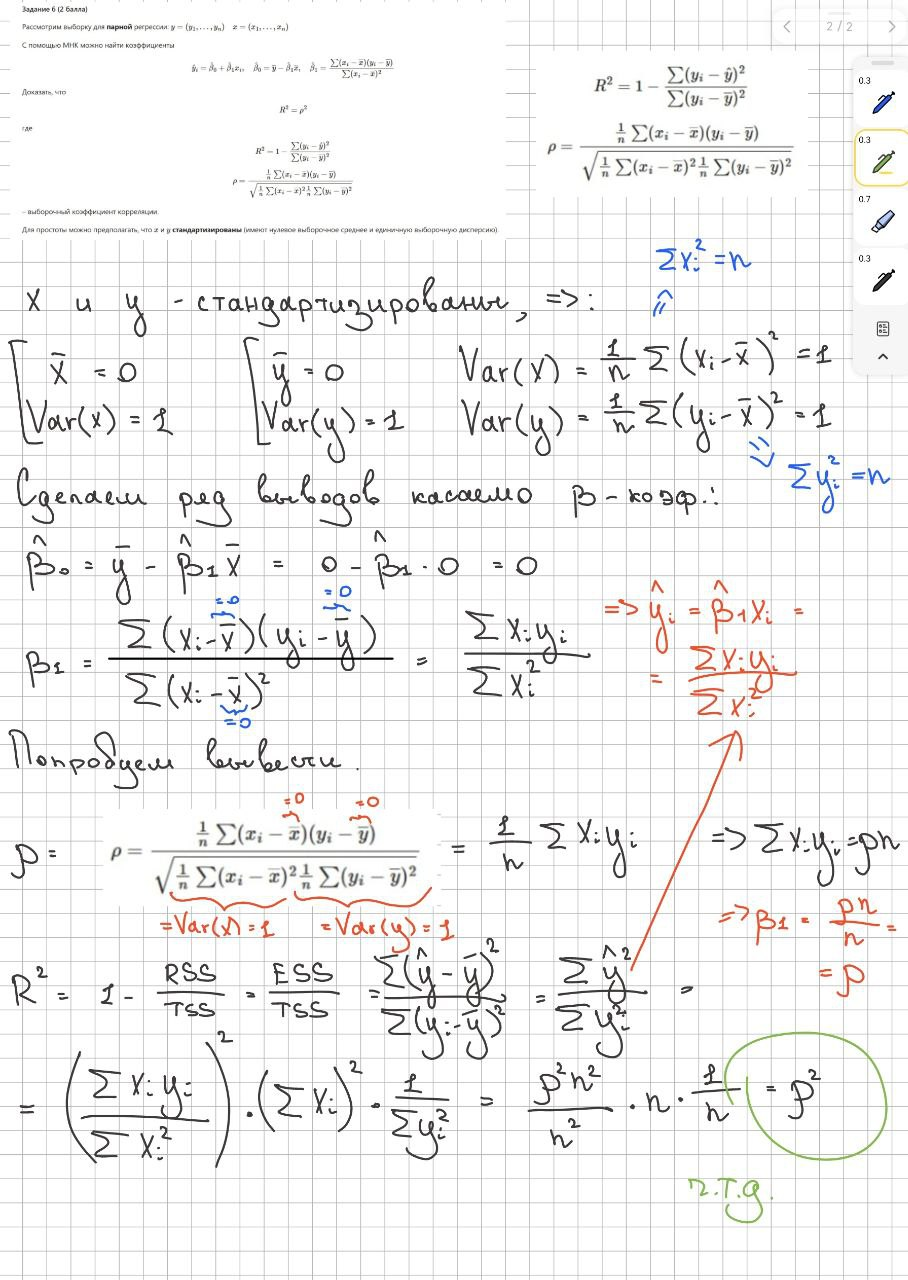

In [173]:
display(Image(filename="r_squared_corr_squared_solved.jpg"))

#### Решение в LaTeX:

$X$ и $y$ - стандартизированы, $\Rightarrow$:

$$
\begin{cases}
\bar{x} = 0 \\
Var(x) = 1
\end{cases}
\quad
\begin{cases}
\bar{y} = 0 \\
Var(y) = 1
\end{cases}
$$

$$Var(x) = \frac{1}{n} \sum (x_i - \bar{x})^2 = 1 \Rightarrow \sum x_i^2 = n$$
$$Var(y) = \frac{1}{n} \sum (y_i - \bar{y})^2 = 1 \Rightarrow \sum y_i^2 = n$$

**Сделаем ряд выводов касаемо $\beta$-коэф.:**

$$\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x} = 0 - \hat{\beta}_1 \cdot 0 = 0$$

$$\hat{\beta}_1 = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2} = \frac{\sum x_i y_i}{\sum x_i^2}$$
*(учтено $\bar{x}=0, \bar{y}=0$)*

$$\Rightarrow \hat{y}_i = \hat{\beta}_1 x_i = \frac{\sum x_i y_i}{\sum x_i^2} \cdot x_i$$

**Попробуем вывести $\rho$:**

$$\rho = \frac{\frac{1}{n} \sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\frac{1}{n}\sum(x_i-\bar{x})^2} \sqrt{\frac{1}{n}\sum(y_i-\bar{y})^2}} = \frac{1}{n} \sum x_i y_i$$
*(знаменатель $= Var(x) \cdot Var(y) = 1 \cdot 1 = 1$)*

$$\Rightarrow \sum x_i y_i = \rho n$$
$$\Rightarrow \hat{\beta}_1 = \frac{\rho n}{n} = \rho$$

**Расчет $R^2$:**

$$R^2 = 1 - \frac{RSS}{TSS} = \frac{ESS}{TSS} = \frac{\sum (\hat{y}_i - \bar{y})^2}{\sum (y_i - \bar{y})^2} = \frac{\sum \hat{y}_i^2}{\sum y_i^2}$$

*Подставляем выражение для $\hat{y}_i$:*

$$= \left( \frac{\sum x_i y_i}{\sum x_i^2} \right)^2 \cdot \left( \sum x_i^2 \right) \cdot \frac{1}{\sum y_i^2} =$$

$$= \frac{\rho^2 n^2}{n^2} \cdot n \cdot \frac{1}{n} = \rho^2$$

**ч.т.д.**